En esta version 2 voy a repetir las pruebas del original pero poniendo equilibrando el undersampling solo de los datos de entrenamiento, y eligiendo parcelas enteras como datos de test.

In [12]:
def algoritmo(df2, fecha, show, parcela):
    diasTotales = 365 + 31
    #from IPython.core.display import display, HTML
    #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import datetime

    import warnings
    warnings.filterwarnings("ignore")
    
    borrarDebajo = 0.15
    
    fechas = list()
    fechas2 = list()
    valores = list()
    valores2= list()
    N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

    #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
    #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
    for i in range(N):
        data = df2.iloc[i].fecha
        data = str(data)
        #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
        dt = datetime.datetime.strptime(data, "%Y%m%d")
        dtInt = int(dt.strftime("%j"))
        if int(data) >= 20220000:
            dtInt = dtInt +365
        #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
        #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
        fechas.append(dtInt)
        ndvi = df2.iloc[i].ndvi
        valores.append(ndvi)
        #Solo añado si el valor está por encima de la variable "borrarDebajo"
        if ndvi >= borrarDebajo:
            valores2.append(ndvi)
            fechas2.append(dtInt)

    #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
    #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
    #Si tenemos los valores [3,1,4], borramos el valor 1
    #Borramos los valores valle
    for i in range(len(valores2)-1):
        if i > 0 and i < len(valores2)-1:
            #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
            if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                del valores2[i]
                del fechas2[i]
                del valores2[i]
                del fechas2[i]
            #En el caso de que solo haya un minimo entre 2 puntos
            elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                del valores2[i]
                del fechas2[i]        






    #Variables:
    saltoFechas = 10
    saltoFechas2 = 20
    saltoFechas3 = 30
    añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
    añadirPorEncima = 0.2

    #Añado informacion al principio y final de año si no habia
    if fechas2[0] > 0:
        fechas2.insert(0, 0)
        valores2.insert(0, valores2[0])
    if fechas2[len(fechas2) -1] < diasTotales:
        fechas2.insert(len(fechas2), diasTotales)
        valores2.insert(len(valores2), valores2[len(valores2)-1])


    #Si hay saltos muy grandes sin informacion se trata:
    i = 0
    while i < len(fechas2) - 1: 
        encontrado = False
        #Si el salto es muy grande
        if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
            #buscar maximos locales entre los dos puntos y
            aux1 = 0
            aux2 = 0
            for j in range(len(fechas) - 1):
                if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                    aux1 = j
                elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                    aux2 = j
                    break
            j = aux1 + 1
            auxSum = 0
            while (j < aux2):
                if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                    # y volverlos a añadir segun su valor
                    if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                        fechas2.insert(i+1+ auxSum, fechas[j])
                        valores2.insert(i+1+ auxSum, valores[j])
                        auxSum = auxSum + 1
                        encontrado = True
                j = j + 1



        if encontrado == False:    
            #Si el salto es intermedio
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                if valores2[i+1] > valores2[i]: #va hacia arriba
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                    valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                else: #va hacia abajo
                    fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                    valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
            #Si el salto es pequeño
            elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
        i = i+1


    #Plot    
    from scipy.interpolate import make_interp_spline
    from scipy.interpolate import interp1d

    #Esto crea una linea de <diasTotales> puntos que pasa por todos los puntos que teniamos
    X_Y_Spline = make_interp_spline(fechas2,valores2)        
    X = np.linspace(0, diasTotales, diasTotales)
    Y = X_Y_Spline(X)

    dt = datetime.datetime.strptime(fecha, "%Y%m%d")
    aux = int(dt.strftime("%j"))
    
    if (show):
        plt.figure(figsize=(17,5))
        plt.title('parcela: '+ parcela)
        plt.plot(fechas, valores,'r-')

        plt.xticks(np.arange(0, diasTotales,10))

        plt.plot(X, Y, 'b-')
        plt.scatter(fechas, valores, c=valores, cmap='Set2')

        #Dibujar las lineas verticales asociadas a las fechas de recepcion
        #for recepcion in recepciones:
        #    if recepcion[0] == parcela:
        #        for aux in recepcion[1]:
        #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
        #            aux2 = int(dt.strftime("%j"))
        #            plt.axvline(x=(aux2))  
        #        break

        #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        #aux = int(dt.strftime("%j"))
        plt.axvline(x=(aux))  



        plt.xlabel("X")
        plt.ylabel("Y")
        plt.ylim([0, 1])
        plt.legend(["puntos originales","puntos modificados"])
        plt.show()
        
    return [Y, aux]

def obtenerColumnas():
    columnas = list()
    columnas.append('parcela')
    columnas.append('dia')
    columnas.append('pendiente dia -15')
    columnas.append('pendiente dia -10')
    columnas.append('pendiente dia -5')
    columnas.append('ndvi')
    columnas.append('recogido')
    
    return columnas

def inicializarDataframeIA(columnas):
    import pandas as pd
    df_ia = pd.DataFrame(columns=columnas())
    
    return df_ia

def obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd

    dfFechas = pd.read_csv(PARCELASMAIZ20212022CONFECHAS)
    
    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)
    
    return only_1_reception

def añadirADataframe(parcela, diaDeCarga, valoresDias, columnas, df,diasPendiente, diasMargen):
    import pandas as pd
    for i in range(len(valoresDias)):
        if ((i - (diasPendiente[0])) >= 0 and (i+1) - diaDeCarga > -15 and (i+1) - diaDeCarga <= 5  ):
            
            lista = list()
            lista.append(parcela)
            lista.append(i + 1)
            for j in diasPendiente:
                lista.append((valoresDias[i - j] - valoresDias[i])/j)
                
            lista.append(valoresDias[i])
            if ((diaDeCarga - (i + 1)) <= diasMargen and (diaDeCarga - (i + 1)) >= 0):
                lista.append(1)
            else:
                lista.append(0)

            dfAux = pd.DataFrame([lista], columns=columnas(), index=[len(df)])
            df = df.append(dfAux)
    
    
    return df


def obtenerDatosEntrenables(datosNoEntrenables2122, PARCELASMAIZ20212022CONFECHAS):
    import pandas as pd
    dfFechas = obtenerParcelasConUnaRecepcion(PARCELASMAIZ20212022CONFECHAS)
    
    
    dfDatos = pd.read_csv(datosNoEntrenables2122)
    dfDatos = dfDatos.sort_values(by=["fecha","parcela"], ascending=True)
    
    parcelasQueTengo = dfDatos["parcela"].unique()
    parcelasConUnaRecepcion = dfFechas["PAC"].unique()

    df_ndvi_of_only_1_reception = dfDatos[dfDatos.parcela.isin(dfFechas["PAC"].unique())]
    parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    
    
    df = inicializarDataframeIA(obtenerColumnas)
    i = 0
    j = len(parcelas)
    diaPrimeraRecepcion = [15,10,5]
    diaMargen = 4
    
    
    for parcela in parcelas:

        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = dfFechas.loc[dfFechas["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]
            X, dia_recepcion = algoritmo(df2, fecha, True, parcela)
            if (dia_recepcion > diaPrimeraRecepcion[0]):
                df = añadirADataframe(parcela, dia_recepcion, X, obtenerColumnas, df, diaPrimeraRecepcion, diaMargen)
            i = i + 1
            print(str(i) + "/" + str(j)) 
        else:
            j = j - 1
        

    return df

def separarTrainTest(dataframe):
    parcelas = dataframe['parcela'].unique()
    N = len(parcelas)

    #si hay 2 recintos de la misma zona uno lo meto a test
    test= list()
    train = list(parcelas)
    contador = 1
    for i in range(N):
        parcelaAnterior = parcelas[i - 1].split('_')
        aux = ''
        for j in range(5):
            aux = aux + parcelaAnterior[j] + '_'


        if parcelas[i].startswith(aux):
            test.append(parcelas[i])
            train.remove(parcelas[i])
            if len(test) >= N * 0.1:
                break

    dataframeTrain = dataframe[dataframe['parcela'].isin(train)]
    dataframeTest =  dataframe[dataframe['parcela'].isin(test)]
    
    return [dataframeTrain, dataframeTest]

def obtenerModelo(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo3(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    #model.add(Dense(n**2, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu',input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo4(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu',  kernel_regularizer=l2(regularizacion)))
    model.add(Dense(n, activation='relu', kernel_regularizer=l2(regularizacion)))
    model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(regularizacion)))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall', threshold = 0.6)])
    model.summary()
    
    return model

def obtenerModelo5(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.constraints import MaxNorm
    from tensorflow.keras.optimizers import SGD
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    normalizer = layers.Normalization()
    normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    model.add(normalizer)
    #,kernel_initializer=initializer
    # Compile model
    #añadir capa
    model.add(Dense(n, activation='relu', input_shape=(n,), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation='relu', kernel_constraint=MaxNorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    #
    sgd = SGD(learning_rate=0.1, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=sgd,  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

def obtenerModelo2(dataframeTrain):
    # Perceptron de un solo nivel
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    normalizer = layers.Normalization()
    normalizer.adapt(X) 
    
    model = Sequential()
    
    #model.add(normalizer)
    
    model.add(Dense(4096, kernel_initializer='normal',input_dim = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1], activation='sigmoid'))

    # The Hidden Layers :
    model.add(Dense(2048 ,activation='softmax'))
    model.add(Dense(1024 ,activation='sigmoid'))
    model.add(Dense(512,activation='relu'))
    model.add(Dense(256,activation='softmax'))
    model.add(Dense(128,activation='sigmoid'))
    model.add(Dense(64,activation='relu'))
    model.add(Dense(32,activation='softmax'))
    model.add(Dense(16,activation='sigmoid'))
    model.add(Dense(8,activation='relu'))
    model.add(Dense(4,activation='softmax'))
    
    model.add(Dense(2, activation='softmax'))
    #
    model.compile(loss='categorical_crossentropy', optimizer=Adam(),  metrics=['accuracy'])
    model.summary()
    
    return model

def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    fig, axs = plt.subplots(1, 2,  figsize=(12, 6))
    for l in loss_list:
        axs[0].plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        axs[0].plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    axs[0].set(title='Loss', xlabel='Epochs', ylabel='Loss')
    axs[0].grid()
    axs[0].legend()
    
    ## Accuracy
    for l in acc_list:
        axs[1].plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        axs[1].plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    axs[1].set(title='Accuracy', xlabel='Epochs', ylabel='Accuracy')
    axs[1].grid()
    axs[1].legend()
    plt.show()
    
def anyadirUnos(df):
    df['unos'] = [1]*len(df)
    
def RecepcionToBool(recogido):
    aux = np.zeros(2)
    aux[recogido] = 1
    return aux
            
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    #plt.tight_layout()

def plot_mnist_confusion_matrix(y_test, y_pred, normalize=False):
    from sklearn.metrics import confusion_matrix
    
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    umbral = 0.01
    
    y_tst = np.zeros(len(y_test))
    for i in range(len(y_test) - 1):
        #if y_test[i][1] >= umbral:
        #    y_tst[i] = 1
        y_tst[i] = np.argmax(y_test[i])
    #y_tst = [np.argmax(y) for y in y_test]
    
    y_prd = np.zeros(len(y_pred))
    for i in range(len(y_pred) - 1):
        #if y_pred[i][1] >= umbral:
        #    y_prd[i] = 1
        y_prd[i] = np.argmax(y_pred[i])
    #y_prd = [np.argmax(y) for y in y_pred]

    cnf_matrix = confusion_matrix(y_tst, y_prd)
    
    yprueba = list()
    for y in y_tst:
        yprueba.append(y)
    for y in y_prd:
        yprueba.append(y)
    class_names=np.unique(yprueba)
    print(class_names)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          normalize=normalize)
    
def quitarDatosMalos(df):
    #QUITA LAS PARCELAS QUE NO TENGAN 20 DIAS DE DATOS
    parcelasAQuitar = list()
    parcelas = df['parcela'].unique()
    for parcela in parcelas:
        if len(df.loc[df['parcela'] == parcela]) != 20:
            parcelasAQuitar.append(parcela)
    
    df = df[~df['parcela'].isin(parcelasAQuitar)]
    return df
    
def anyadirRelacionesParametros2(df):
    columnas = df.shape[1]
    for i in range(columnas):
        for j in range(columnas):
            if i < j:
                nombreColumna = 'col ' + str(i+1) + ' * col ' + str(j+1)
                df[nombreColumna] = df.iloc[:,i] * df.iloc[:,j]
                
    return df
    
def anyadirRelacionesParametros(df, listaColumnas = ['parcela','dia','recogido','ndvi']):
    aux = pd.DataFrame()
    for i in listaColumnas:
        aux[i] = df[i]
        df = df.drop(columns=[i])
        
    df = anyadirRelacionesParametros2(df)
    for i in listaColumnas:
        df[i] = aux[i]
    return df
    
def entrenarModelo(model, dataframeTrain, dataframeTest, batch_size, epochs, callbacks_list):
    def RecepcionToBool(recogido):
        aux = np.zeros(2)
        aux[recogido] = 1
        return aux

    #DATA TRAINING   
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers
    N = len(dataframeTrain)


    verbose = True
    t0 = time.perf_counter()
    X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    y = np.asarray(dataframeTrain[["recogido"]]).astype(np.float32)
    
    #DATA TESTING
    N = len(dataframeTest)

    Xtest = np.asarray(dataframeTest.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    ytest = np.asarray(dataframeTest[["recogido"]]).astype(np.float32)
    


    history = model.fit(X, y,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=False, 
                        callbacks=callbacks_list,
                       validation_data=(Xtest,ytest))

    #model.predict(X_cv)

    train_time = time.perf_counter() - t0
    print('%s %.3f%s' %  ('Training time: ', train_time, 's') )
    plot_history(history)
    
def predecirYMostrarMatrizConfusion(df,model,pesos, umbral = 0.6):
    df = df.reset_index()
    df = df.drop(columns=['index'])
    X = df.drop(columns=['parcela','dia','recogido'])
    y = df['recogido']
    
    X=np.asarray(X).astype(np.float)

    y=np.asarray(y).astype(np.float)
    
    model.load_weights(pesos)
    
    
    
    y_pred = model.predict(X, verbose=True)
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(y_pred)):
        if y_pred[i] >= umbral and y[i] == 1:
            tp = tp + 1
        elif y_pred[i] >= umbral and y[i] == 0:
            fp = fp + 1
        elif y_pred[i] < umbral and y[i] == 1:
            fn = fn + 1
        else:
            tn = tn + 1


    test_score = (tp + tn)/ len(X)
    print('%s %2.2f%s' % ('Accuracy test:  ', 100*test_score, '%'))

    import seaborn as sn
    import pandas as pd
    import matplotlib.pyplot as plt
    ind = np.asarray([0.0,1.0]).astype(np.float32)
    mat = np.asarray([[tn, fp], [fn, tp]]).astype(np.int32)
    plt.figure(figsize=(20,20))
    plot_confusion_matrix(mat, classes=ind,
                              normalize=False)



# Define la función de poda
def prune_low_weights(model, pruning_threshold):
    from keras import backend as K
    for layer in model.layers:
        if hasattr(layer, 'kernel_regularizer'):
            weights = layer.get_weights()[0]  # Obtiene los pesos de la capa
            mask = K.abs(weights) > pruning_threshold  # Aplica el umbral
            weights *= mask  # Poda los pesos por debajo del umbral
            layer.set_weights([weights])  # Establece los pesos podados en la capa
            
def parcelasConAciertos(dataframe,model,  umbral = 0.6, verbose=1, XGBoost = False, LGBM= False):
    import lightgbm as lgb
    import xgboost as xgb
    dataframeRecogidoUno = dataframe.loc[dataframe['recogido'] == 1]
    parcelasAObservar = dataframe['parcela'].unique()
    parcelasSinResultado = list(dataframe['parcela'].unique())
    if verbose == 1:
        print(len(parcelasSinResultado))
        print("hay ", str(len(parcelasAObservar)), " parcelas a observar")
        print('------------------')
    cantidad = 0
    for parcela in parcelasAObservar:
        unoAcertado = False
        datos = dataframe.loc[dataframe['parcela'] == parcela]
        dias = dataframeRecogidoUno.loc[dataframeRecogidoUno['parcela'] == parcela]['dia']
        if verbose == 1:
            print(parcela, 'dias que deberia dar 1 la prediccion:')
            print(dias)
        Xtest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
        ytest = np.asarray(dataframe.loc[dataframe['parcela'] == parcela][["recogido"]]).astype(np.float32)
        
        # preparar datos de xgboost
        if XGBoost == True:
            X_test = pd.DataFrame(Xtest, columns=dataframe.drop(columns=['recogido','parcela','dia']).columns)
            Xtest = xgb.DMatrix(X_test, label=ytest)
        # preparar datos de lgbm
        elif LGBM == True:
            X_test = pd.DataFrame(Xtest, columns=dataframe.drop(columns=['recogido','parcela','dia']).columns)
            Xtest = X_test.values
        
        # predicciones
        if hasattr(model, 'predict_proba'):
            ypred = model.predict_proba(Xtest)[:,1]
        else:
            if 'verbose' in model.predict.__code__.co_varnames:
                ypred = model.predict(Xtest, verbose=verbose)
            else:
                ypred = model.predict(Xtest)
            
            
        if verbose == 1:
            print("dias que ha dado 1 la prediccion: ")
        for i in range(len(ypred)):
            if ypred[i] >= umbral:
                if verbose == 1:
                    print('dia: ', datos.iloc[i]['dia'])
                if ytest[i] == 1 and unoAcertado == False:
                    cantidad = cantidad + 1
                    unoAcertado = True
                    
                    
        if (unoAcertado == True):
            if verbose == 1:
                print("ha acertado por lo menos un 1 de los que deberia")
            parcelasSinResultado.remove(parcela)

        if verbose == 1:
            print('------------------')

    print('Parcelas con acierto: ',cantidad, "de", str(len(parcelasAObservar)) , " ", "{:.2%}".format(cantidad/len(parcelasAObservar)))
    return [parcelasAObservar, parcelasSinResultado]
    
    
def obtenerMejorModelo(directory_init = ''):
    import os
    import ipynbname
    if directory_init == '':
        directory = ipynbname.name()
    else:
        directory = directory_init
    baccuracyMax = 0
    baccuracyMaxFile = ''
    val_baccuracyMax = 0
    val_baccuracyMaxFile = ''
    recallMax = 0
    recallMaxFile = ''
    val_recallMax = 0
    val_recallMaxFile = ''
    # iterate over files in
    # that directory
    for subdirectory in os.listdir(directory):
        f = os.path.join(directory, subdirectory)
        # checking if it is a file
        for filename in os.listdir(f):
            campos = filename.split('-')
            f1 = os.path.join(f, filename)
            if (len(campos)) == 5:
                if (campos[3] == 'binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(baccuracyMax)):
                    baccuracyMax = float(campos[4][:len(campos[4])-5])
                    baccuracyMaxFile = f1
                if (campos[3] == 'val_binary_accuracy' and float(campos[4][:len(campos[4])-5]) > float(val_baccuracyMax)):
                    val_baccuracyMax = float(campos[4][:len(campos[4])-5])
                    val_baccuracyMaxFile = f1
                if (campos[3] == 'recall' and float(campos[4][:len(campos[4])-5]) > float(recallMax)):
                    recallMax = float(campos[4][:len(campos[4])-5])
                    recallMaxFile = f1
                if (campos[3] == 'val_recall' and float(campos[4][:len(campos[4])-5]) > float(val_recallMax)):
                    val_recallMax = float(campos[4][:len(campos[4])-5])
                    val_recallMaxFile = f1

    print("Mejor binary_accuracy: ", baccuracyMax)
    print(baccuracyMaxFile)
    print("Mejor val_binary_accuracy: ", val_baccuracyMax)
    print(val_baccuracyMaxFile)
    print("Mejor recall: ", recallMax)
    print(recallMaxFile)
    print("Mejor val_recall: ", val_recallMax)
    print(val_recallMaxFile)


In [13]:
def mostrarParcelasSinAciertos(parcelasAObservar):

    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]







            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion", "falsos positivo"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    parcelas = parcelasAObservar
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])


            X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)

            i = i + 1





def mostrarParcelasConAciertos(parcelasAObservar):
    def intersection(lst1, lst2):
                lst3 = [value for value in lst1 if value in lst2]
                return lst3
    def algoritmo(df2, fecha, show, tp, fp):

        #from IPython.core.display import display, HTML
        #display(HTML("<style>div.output_scroll { height: 90em; }</style>"))

        import pandas as pd
        import matplotlib.pyplot as plt
        import numpy as np
        import datetime

        import warnings
        warnings.filterwarnings("ignore")

        borrarDebajo = 0.15

        fechas = list()
        fechas2 = list()
        valores = list()
        valores2= list()
        N = int(df2.size / 3) #numero de valores que tenemos para esta parcela

        #Almacenamos los datos originales de la parcela en 'fechas' y 'valores'
        #En 'fechas2' y 'valores2' almacenamos los datos cuyo ndvi esté por encima de 'borrarDebajo'
        for i in range(N):
            data = df2.iloc[i].fecha
            data = str(data)
            #Esto convierte la cadena YYYYMMDD en un tipo de dato fecha
            dt = datetime.datetime.strptime(data, "%Y%m%d")
            #Convierto ese tipo de dato fecha en un entero, el dia del año de esa fecha
            #Ej. 20210202 es el 2 de febrero y es el dia 33 del año
            fechas.append(int(dt.strftime("%j")))
            ndvi = df2.iloc[i].ndvi
            valores.append(ndvi)
            #Solo añado si el valor está por encima de la variable "borrarDebajo"
            if ndvi >= borrarDebajo:
                valores2.append(ndvi)
                fechas2.append(int(dt.strftime("%j")))

        #Borramos de 'valores2' y 'fechas2' los datos cuyos ndvi sean menores que el dato anterior y al siguiente (valores valle)
        #Ejemplo: si tenemos los valores [3,1,2,4], borramos los valores 1 y 2
        #Si tenemos los valores [3,1,4], borramos el valor 1
        #Borramos los valores valle
        for i in range(len(valores2)-1):
            if i > 0 and i < len(valores2)-1:
                #Si hay 2 valores juntos menores que el anterior y el siguiente, se borran ambos
                if i < (len(valores2) - 2) and valores2[i-1] > valores2[i] and valores2[i-1] > valores2[i+1] and valores2[i+2] > valores2[i] and valores2[i+2] > valores2[i+1]:
                    del valores2[i]
                    del fechas2[i]
                    del valores2[i]
                    del fechas2[i]
                #En el caso de que solo haya un minimo entre 2 puntos
                elif valores2[i-1] > valores2[i] and valores2[i+1] > valores2[i]:
                    del valores2[i]
                    del fechas2[i]        






        #Variables:
        saltoFechas = 10
        saltoFechas2 = 20
        saltoFechas3 = 30
        añadirPorDebajo = 0.4 #antes se llamaba maximoMinimo
        añadirPorEncima = 0.2

        #Añado informacion al principio y final de año si no habia
        if fechas2[0] > 0:
            fechas2.insert(0, 0)
            valores2.insert(0, valores2[0])
        if fechas2[len(fechas2) -1] < 365:
            fechas2.insert(len(fechas2), 365)
            valores2.insert(len(valores2), valores2[len(valores2)-1])


        #Si hay saltos muy grandes sin informacion se trata:
        i = 0
        while i < len(fechas2) - 1: 
            encontrado = False
            #Si el salto es muy grande
            if (fechas2[i+1]-fechas2[i]) >= saltoFechas3 and i+1 != (len(fechas2) -1) and i != 0:
                #buscar maximos locales entre los dos puntos y
                aux1 = 0
                aux2 = 0
                for j in range(len(fechas) - 1):
                    if fechas[j] <= fechas2[i] and fechas[j+1] >= fechas2[i]:
                        aux1 = j
                    elif fechas[j] <= fechas2[i]  and fechas[j+1] >= fechas2[i]   :
                        aux2 = j
                        break
                j = aux1 + 1
                auxSum = 0
                while (j < aux2):
                    if valores[j] > valores[j-1] and valores[j] > valores[j+1]:
                        # y volverlos a añadir segun su valor
                        if (valores2[i] <= 0.6 and valores2[i+1] <=0.6 and valores[j] <= añadirPorDebajo and valores[j] >= añadirPorEncima):
                            fechas2.insert(i+1+ auxSum, fechas[j])
                            valores2.insert(i+1+ auxSum, valores[j])
                            auxSum = auxSum + 1
                            encontrado = True
                    j = j + 1



            if encontrado == False:    
                #Si el salto es intermedio
                if (fechas2[i+1]-fechas2[i]) >= saltoFechas2:
                    if valores2[i+1] > valores2[i]: #va hacia arriba
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3)*2)
                        valores2.insert(i+1, valores2[i] + ((valores2[i+1] - valores2[i]) / 3))
                    else: #va hacia abajo
                        fechas2.insert(i+1, fechas2[i] + ((fechas2[i+1] - fechas2[i]) / 3))
                        valores2.insert(i+1,  valores2[i+1] + ((valores2[i] - valores2[i+1]) / 3))
                #Si el salto es pequeño
                elif (fechas2[i+1]-fechas2[i]) >= saltoFechas:
                    fechas2.insert(i+1, (fechas2[i+1]+fechas2[i])/2)
                    valores2.insert(i+1, (valores2[i+1]+valores2[i])/2)
            i = i+1


        #Plot    
        from scipy.interpolate import make_interp_spline
        from scipy.interpolate import interp1d

        #Esto crea una linea de 365 puntos que pasa por todos los puntos que teniamos
        X_Y_Spline = make_interp_spline(fechas2,valores2)        
        X = np.linspace(0, 365, 365)
        Y = X_Y_Spline(X)

        dt = datetime.datetime.strptime(fecha, "%Y%m%d")
        aux = int(dt.strftime("%j"))

        if (show):
            plt.figure(figsize=(17,5))
            plt.title('parcela: '+ parcela)
            plt.plot(fechas, valores,'r-')

            plt.xticks(np.arange(0, 365,10))

            plt.plot(X, Y, 'b-')
            plt.scatter(fechas, valores, c=valores, cmap='Set2')

            #Dibujar las lineas verticales asociadas a las fechas de recepcion
            #for recepcion in recepciones:
            #    if recepcion[0] == parcela:
            #        for aux in recepcion[1]:
            #            dt = datetime.datetime.strptime(aux, "%Y%m%d")
            #            aux2 = int(dt.strftime("%j"))
            #            plt.axvline(x=(aux2))  
            #        break

            #dt = datetime.datetime.strptime(fecha, "%Y%m%d")
            #aux = int(dt.strftime("%j"))
            plt.axvline(x=(aux), linewidth=2, color='black') 
            print('dia de recepcion: ',aux)
            interseccion = intersection(tp,fp)
            print('true positives: ', interseccion)


            [plt.axvline(_x, linewidth=1, color='orange') for _x in interseccion]

            if len(interseccion) > 0:
                for i in interseccion:
                    tp.remove(i)
                    fp.remove(i)
            [plt.axvline(_x, linewidth=1, color='g') for _x in tp]
            [plt.axvline(_x, linewidth=1, color='r') for _x in fp]





            plt.xlabel("X")
            plt.ylabel("Y")
            plt.ylim([0, 1])
            plt.legend(["puntos originales","puntos modificados","recepcion"])
            plt.show()

        return [Y, aux]

    import pandas as pd
    import numpy as np

    dfFechas = pd.read_csv('PARCELAS-MAIZ-2021-2022-CON-FECHAS.csv')

    freq = dfFechas['PAC'].value_counts()
    items = freq[freq==1].index
    only_1_reception = dfFechas[dfFechas['PAC'].isin(items)]

    newPac = only_1_reception["PAC"].str.replace(":", "_")
    newDate = only_1_reception["Fecha de carga"].str.replace("-", "")

    only_1_reception["PAC"] = newPac
    only_1_reception["Fecha de carga"] = newDate
    only_1_reception['Fecha de carga'] = only_1_reception['Fecha de carga'].apply(str)

    df = pd.read_csv('TODOSLOSRECINTOS.csv')

    #Ordeno por fecha y parcela
    sorted_df = df.sort_values(by=["fecha","parcela"], ascending=True)
    sorted_df = sorted_df.drop(columns=['Unnamed: 0'])
    parcelasQueTengo = sorted_df["parcela"].unique()
    parcelasConUnaRecepcion = only_1_reception["PAC"].unique()

    df_ndvi_of_only_1_reception = sorted_df[sorted_df.parcela.isin(only_1_reception["PAC"].unique())]

    dias1 = 7
    dias2 = 180


    i = 0
    #parcelas = df_ndvi_of_only_1_reception['parcela'].unique()
    dataframeAux = dataframeTest
    parcelas = dataframeAux['parcela'].unique()
    for parcela in parcelas:
        df2 = df_ndvi_of_only_1_reception.loc[df_ndvi_of_only_1_reception['parcela'] == parcela]
        df2 = df2.drop_duplicates()
        if (not df2.empty):
            fecha_df = only_1_reception.loc[only_1_reception["PAC"] == parcela] 
            fecha = fecha_df.iloc[0]["Fecha de carga"]

            datos = dataframeAux.loc[dataframeAux['parcela'] == parcela]
            dias = dataframeDias.loc[dataframeDias['parcela'] == parcela]['dia']
            #print('------------------')
            #print(parcela, 'dias:')
            tp = list(dias)
            #print(dias)
            Xtest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])).astype(np.float32)
            ytest = np.asarray(dataframeAux.loc[dataframeAux['parcela'] == parcela][["recogido"]]).astype(np.float32)
            ypred = model.predict(Xtest, verbose=0)
            fp = list()
            #print(len(ypred))
            for i in range(len(ypred)):
                if ypred[i] >= 0.6:
                    fp.append(datos.iloc[i]['dia'])

            #print(tp, fp)
            if len(intersection(tp, fp)) > 0:
                X, dia_recepcion = algoritmo(df2, fecha, True, tp, fp)


            i = i + 1




El modelo de red neuronal:

In [14]:
def obtenerModelo20230110(dataframeTrain, regularizacion=1):
    # Perceptron de un solo nivel
    from keras.layers import Dense
    from keras.regularizers import l2
    import keras
    from keras.datasets import mnist
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Flatten
    from tensorflow.keras.optimizers import RMSprop, Adam, SGD
    from keras.callbacks import EarlyStopping
    import time
    import numpy as np
    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix
    import tensorflow as tf
    from tensorflow.keras import layers

    
    #X = np.asarray(dataframeTrain.drop(columns=['parcela','dia','recogido'])).astype(np.float32)
    
    #normalizer = layers.Normalization()
    #normalizer.adapt(X)
    
    n = dataframeTrain.drop(columns=['parcela','dia','recogido']).shape[1]

    model = Sequential()
    
    #model.add(normalizer)
    #,kernel_initializer=initializer
    #model.add(Dense(n**3, activation='relu', input_shape=(n,), kernel_regularizer=l2(regularizacion)))
    #añadir capa
    model.add(Dense(n**2, activation='relu', input_shape=(n,) ))
    model.add(Dense(n, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    #
    model.compile(loss='binary_crossentropy', optimizer=Adam(),  metrics=[tf.keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=0.6), keras.metrics.Recall(name='recall')])
    model.summary()
    
    return model

La funcion de exito:

In [15]:
def funcionExito(ypred, dia, diaRecogida):
    import math
    if  abs(dia - diaRecogida) == 0:
        return ypred
    else: 
        return ypred / (1 + math.log(1 + abs(dia - diaRecogida),10))


def exito(dataframeTest,model, funcionExito, verbose = 1, XGBoost = False, LGBM = False):
    import xgboost as xgb
    import lightgbm as lgb
    promedio = 0
    maxexito = 0
    minexito = 9999
    for parcela in dataframeTest['parcela'].unique():
        maximo = 0
        X = dataframeTest.loc[dataframeTest['parcela'] == parcela].drop(columns=['parcela','dia','recogido'])
        X=np.asarray(X).astype(np.float)
        if verbose == 1:
            print(dataframeTest.loc[dataframeTest['parcela'] == "22_27_0_1_503_5019_1"])
          
        
        ytest = np.asarray(dataframeTest.loc[dataframeTest['parcela'] == parcela][["recogido"]]).astype(np.float32)
        # preparar datos de xgboost
        if XGBoost == True:
            X_test = pd.DataFrame(X, columns=dataframeTest.drop(columns=['recogido','parcela','dia']).columns)
            X = xgb.DMatrix(X_test, label=ytest)
        # preparar datos de lgbm
        elif LGBM == True:
            X_test = pd.DataFrame(X, columns=dataframeTest.drop(columns=['recogido','parcela','dia']).columns)
            X = X_test.values
        
        if hasattr(model, 'predict_proba'):
            ypred = model.predict_proba(X)[:,1]
        else:
            ypred = model.predict(X)
        dias = dataframeTest.loc[dataframeTest['parcela'] == parcela]['dia']
        diaRecogida = dataframeTest.loc[dataframeTest['parcela'] == parcela].iloc[14]['dia']
        if verbose == 1:
            print("--------")
            print(dias.iloc[1])
            print(res[0])
        for i in range(len(ypred)):
            if verbose == 1:
                print("--------")
                print(ypred[i])
            valorExito = funcionExito(ypred[i], dias.iloc[i], diaRecogida)
            
            if valorExito > maximo:
                maximo = valorExito
                if verbose == 1:
                    print(parcela, ypred[i], maximo, dias.iloc[i] - diaRecogida)

        if verbose == 1:
            print(maximo)
        promedio = promedio + maximo
        if maximo < minexito:
            minexito = maximo
        if maximo > maxexito:
            maxexito = maximo
        
    return [minexito, maxexito, promedio/len(dataframeTest['parcela'].unique())]
            

In [16]:
def mostrarCurvaRoc(y_train, y_train_pred, y_test, y_test_pred):
    from sklearn.metrics import roc_curve, roc_auc_score
    import matplotlib.pyplot as plt

    # Suponiendo que 'y_train_true' y 'y_train_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de entrenamiento
    fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_pred)

    # Suponiendo que 'y_test_true' y 'y_test_pred_prob' son los valores verdaderos y las probabilidades predichas para el conjunto de prueba
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_pred)

    # Graficar las curvas ROC de entrenamiento y prueba en el mismo gráfico
    plt.plot(fpr_train, tpr_train, color='orange', label='Train AUC = {:.2f}'.format(auc_train))
    plt.plot(fpr_test, tpr_test, color='blue', label='Test AUC = {:.2f}'.format(auc_test))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Curva ROC')
    plt.legend()
    plt.show()

In [21]:
def round_threshold(arr, threshold):
    return [1 if x >= threshold else 0 for x in arr]

Voy a repetir las pruebas del fichero 'TemperaturaPrecipitacionSinNdvi-20230110.ipynb' pero usando la libreria Smote para arreglar el undersampling de los datos etiquetados a 1 ya que son 1/4 del total.

Aqui cargamos en df el dataset con los datos validos:

In [18]:
import pandas as pd
import numpy as np

df = pd.read_csv('datosEntrenables20230131-full.csv')
parcelasAQuitar = df.loc[df['estacion'] == 'not inialized']['parcela'].unique()
df = df[~df['parcela'].isin(parcelasAQuitar)]
df = df.drop(columns=['Unnamed: 0','precSum3','estacion'])
df = quitarDatosMalos(df)

In [19]:
import warnings
warnings.filterwarnings("ignore")
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

def entrenarUndersamplingNormalizacion(df, normalizacion=[0,1], params=False,algoritmo= False, random_state=33, umbral=0.5, n_splits=10,
                                    XGBoost = False, LGBM = False):
    import warnings
    warnings.filterwarnings("ignore")
    import xgboost as xgb
    import lightgbm as lgb
    from sklearn.model_selection import KFold
    from sklearn.metrics import precision_score, recall_score, accuracy_score
    from imblearn.over_sampling import SMOTE
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import classification_report
    
    from lightgbm import LGBMClassifier
    from xgboost import XGBClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.naive_bayes import GaussianNB
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
    
    parcelas = df['parcela'].unique() # obtenemos las parcelas

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for train_index, test_index in kf.split(parcelas): # separamos los datos de train y test segun la parcela
        # obtenemos las parcelas de train y test
        parcelasTrain = parcelas[train_index]
        parcelasTest = parcelas[test_index]

        # separamos en 2 df segun las parcelas de train o test
        df_train = df[df['parcela'].isin(parcelasTrain)]
        df_test = df[df['parcela'].isin(parcelasTest)]

        # preparo la normalizacion
        scaler = MinMaxScaler(feature_range=(normalizacion[0], normalizacion[1]))

        # arreglamos undersampling en los datos de train
        smote = SMOTE(sampling_strategy=1, random_state=random_state)
        X_train,y_train = smote.fit_resample(df_train.drop(columns=['recogido','parcela','dia']), df_train['recogido'])
        X_train = scaler.fit_transform(X_train)
        X_train = pd.DataFrame(X_train, columns=df_train.drop(columns=['recogido','parcela','dia']).columns)
        X_train = anyadirRelacionesParametros(X_train, ['tmed','prec','ndvi'])
        anyadirUnos(X_train)

        # preparamos datos de test
        X_test, y_test = df_test.drop(columns=['recogido','parcela','dia']), df_test['recogido']
        X_test = scaler.transform(X_test)
        X_test = pd.DataFrame(X_test, columns=df_test.drop(columns=['recogido','parcela','dia']).columns)
        X_test = anyadirRelacionesParametros(X_test, ['tmed','prec','ndvi'])
        anyadirUnos(X_test)
        
        
        
        if XGBoost == False and LGBM == False:
            assert algoritmo != False
            model = algoritmo(random_state=random_state)
            model.fit(X_train, y_train)
            
            dtrain = X_train
            dtest = X_test
            
        elif XGBoost == True:
            assert params != False
            
            # preparar datos xgboost
            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_test, label=y_test)
            
            model = xgb.train(params, dtrain, num_boost_round=100) 
        elif LGBM == True:
            assert params != False
            
            # preparar datos lgbm
            dtrain = lgb.Dataset(X_train, label=y_train)
            dtest = X_test.values
            
            model = lgb.train(params, dtrain, num_boost_round=100) 
            dtrain = X_train.values
            
            
        if hasattr(model, 'predict_proba'):
            y_pred = model.predict_proba(dtest)[:,1]
            y_train_pred = model.predict_proba(dtrain)[:,1]
        else:
            y_pred = model.predict(dtest)
            y_train_pred = model.predict(dtrain)
            
        y_pred_round = round_threshold(y_pred, umbral)
        

        # Suponiendo que 'y_true' son los valores verdaderos y 'y_pred' son los valores predichos
        report = classification_report(y_test, y_pred_round)

        # Imprimir el informe de clasificación
        print(report)

        mostrarCurvaRoc(y_train, y_train_pred, y_test, y_pred)
        
        # Calcular el numero de parcelas de test que acierta
        X_test2 = X_test
        X_test2['parcela'] = df_test['parcela'].values
        X_test2['recogido'] = df_test['recogido'].values
        X_test2['dia'] = df_test['dia'].values
        [parcelasAObservar, parcelasSinResultado] = parcelasConAciertos(X_test2, model, umbral, verbose = 0, XGBoost=XGBoost, LGBM = LGBM )
        dataframeAux = X_test2
        dataframeDias = X_test2.loc[X_test2["recogido"] == 1]
        
        accuracy = accuracy_score(y_test, y_pred_round)
        
        # Calcular el exito
        [mini,maxi,promedi] = exito(X_test2,model, funcionExito, verbose =0, XGBoost = XGBoost, LGBM = LGBM)
        print("Exito min: ", mini, "\nExito max: ", maxi, "\nExito promedio: ",promedi)
        print("Exito * accuracy = ", promedi*accuracy)
        print("Exito * accuracy / (Exito + accuracy) = ", promedi*accuracy / (promedi + accuracy))
        print("="*50)

-----------------------------------------------------------------------------------------------------------------------------

Prueba con RandomForestClassifier:

              precision    recall  f1-score   support

           0       0.81      0.86      0.84       585
           1       0.49      0.40      0.44       195

    accuracy                           0.75       780
   macro avg       0.65      0.63      0.64       780
weighted avg       0.73      0.75      0.74       780



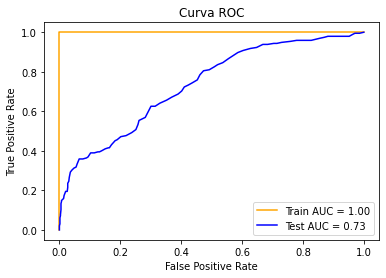

Parcelas con acierto:  26 de 39   66.67%
Exito min:  0.26 
Exito max:  0.95 
Exito promedio:  0.6026059600997441
Exito * accuracy =  0.44963675484365523
Exito * accuracy / (Exito + accuracy) =  0.3333705176851301
              precision    recall  f1-score   support

           0       0.85      0.81      0.83       585
           1       0.50      0.56      0.53       195

    accuracy                           0.75       780
   macro avg       0.67      0.69      0.68       780
weighted avg       0.76      0.75      0.75       780



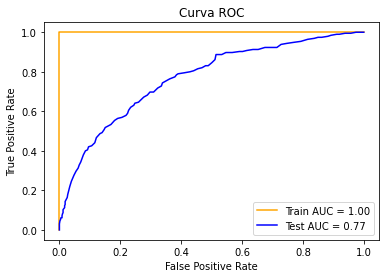

Parcelas con acierto:  34 de 39   87.18%
Exito min:  0.2504872222356728 
Exito max:  0.91 
Exito promedio:  0.6283903248573974
Exito * accuracy =  0.469681486399824
Exito * accuracy / (Exito + accuracy) =  0.34138140325377414
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       585
           1       0.42      0.35      0.38       195

    accuracy                           0.72       780
   macro avg       0.61      0.60      0.60       780
weighted avg       0.70      0.72      0.71       780



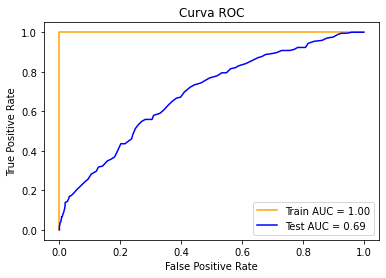

Parcelas con acierto:  27 de 39   69.23%
Exito min:  0.31214140366591964 
Exito max:  0.9 
Exito promedio:  0.5656895115370731
Exito * accuracy =  0.4068613025285872
Exito * accuracy / (Exito + accuracy) =  0.3166432257458456
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       585
           1       0.48      0.39      0.43       195

    accuracy                           0.74       780
   macro avg       0.65      0.63      0.63       780
weighted avg       0.73      0.74      0.73       780



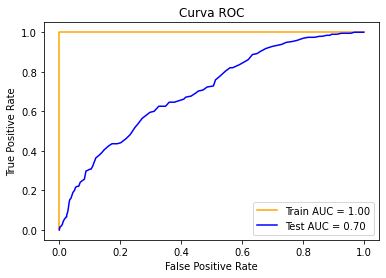

Parcelas con acierto:  29 de 39   74.36%
Exito min:  0.2997624968676939 
Exito max:  0.96 
Exito promedio:  0.5851141347120641
Exito * accuracy =  0.43508486940127844
Exito * accuracy / (Exito + accuracy) =  0.327450590388396
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       570
           1       0.49      0.53      0.51       190

    accuracy                           0.75       760
   macro avg       0.67      0.67      0.67       760
weighted avg       0.75      0.75      0.75       760



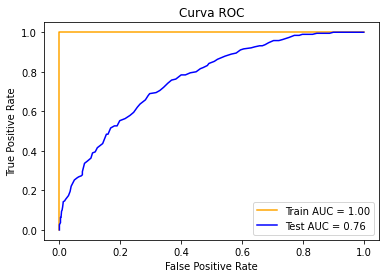

Parcelas con acierto:  33 de 38   86.84%
Exito min:  0.40424870310832217 
Exito max:  0.94 
Exito promedio:  0.6582551443837674
Exito * accuracy =  0.49109298271788965
Exito * accuracy / (Exito + accuracy) =  0.34970466668620687
              precision    recall  f1-score   support

           0       0.84      0.89      0.87       570
           1       0.61      0.49      0.55       190

    accuracy                           0.79       760
   macro avg       0.73      0.69      0.71       760
weighted avg       0.78      0.79      0.79       760



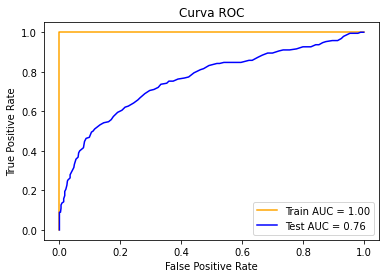

Parcelas con acierto:  29 de 38   76.32%
Exito min:  0.3331059256476636 
Exito max:  0.96 
Exito promedio:  0.608406766414437
Exito * accuracy =  0.4835232722556842
Exito * accuracy / (Exito + accuracy) =  0.34459998913852835
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       570
           1       0.52      0.36      0.42       190

    accuracy                           0.76       760
   macro avg       0.66      0.62      0.64       760
weighted avg       0.74      0.76      0.74       760



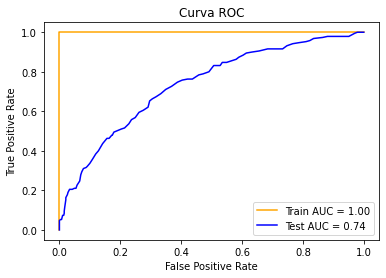

Parcelas con acierto:  25 de 38   65.79%
Exito min:  0.245 
Exito max:  0.9 
Exito promedio:  0.5381983594545042
Exito * accuracy =  0.40789770400762426
Exito * accuracy / (Exito + accuracy) =  0.31471327574626423
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       570
           1       0.50      0.51      0.50       190

    accuracy                           0.75       760
   macro avg       0.67      0.67      0.67       760
weighted avg       0.75      0.75      0.75       760



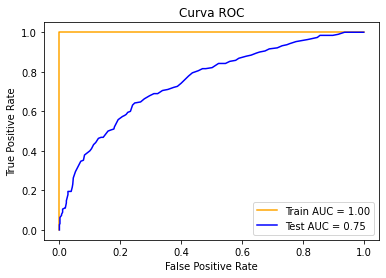

Parcelas con acierto:  32 de 38   84.21%
Exito min:  0.2613314075256819 
Exito max:  0.94 
Exito promedio:  0.6412230546493266
Exito * accuracy =  0.480917290986995
Exito * accuracy / (Exito + accuracy) =  0.3456795007671977
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       570
           1       0.50      0.42      0.46       190

    accuracy                           0.75       760
   macro avg       0.66      0.64      0.65       760
weighted avg       0.74      0.75      0.74       760



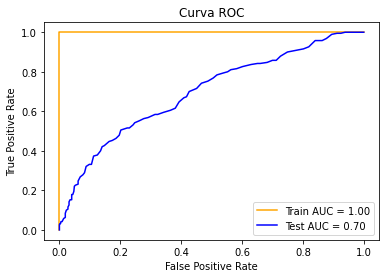

Parcelas con acierto:  30 de 38   78.95%
Exito min:  0.2699432907613669 
Exito max:  0.93 
Exito promedio:  0.5862255944856929
Exito * accuracy =  0.43966919586426967
Exito * accuracy / (Exito + accuracy) =  0.32903814870684045
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       570
           1       0.52      0.35      0.42       190

    accuracy                           0.76       760
   macro avg       0.66      0.62      0.63       760
weighted avg       0.73      0.76      0.74       760



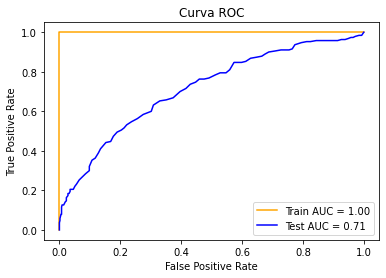

Parcelas con acierto:  26 de 38   68.42%
Exito min:  0.24 
Exito max:  0.95 
Exito promedio:  0.5667458652792173
Exito * accuracy =  0.42953370842214367
Exito * accuracy / (Exito + accuracy) =  0.3242643383679123


In [30]:
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[0,1], 
                                   algoritmo=RandomForestClassifier, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10
                                  )

- Con normalizacion entre 0 y 1 y umbral de 0.6:
  - ningun modelo supera un accuracy de 0.8, el cual era el que tenia con los modelos de redes neuronales.
  - El maximo de parcelas ha sido 34/38 (87%) con un exito de 0.6283903248573974
  - Los mayores exitos han sido de 0.6582551443837674 en una prueba que ha acertado 33/38 parcelas (86%)
- Con normalizacion entre -1 y 1 y umbral de 0.6:
  - hay un modelo que supera el 0.8 de accuracy (0.81) el cual acierta 29/38 (76%) parcelas y tiene un exito de 0.6013442164078103.
  - El maximo de parcelas ha sido 33/38 (86%) con un exito de 0.6190647255078413
  - Los mayores exitos han sido de 0.6484441940639761 y 0.6437199174891078 en 2 pruebas que han acertado 32/38 (84%) parcelas

Con normalizacion entre 0 y 1 obtengo mejores resultados de exito y parcelas con aciertos aunque menos precision global comparada con la normalizacion de -1 a 1.

Misma prueba pero con RandomForestRegressor --se supone que el algoritmo es igual pero obteniendo probabilidad (regresion) en vez de la clase final (clasificacion) --:

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       585
           1       0.57      0.42      0.48       195

    accuracy                           0.77       780
   macro avg       0.69      0.65      0.67       780
weighted avg       0.76      0.77      0.76       780



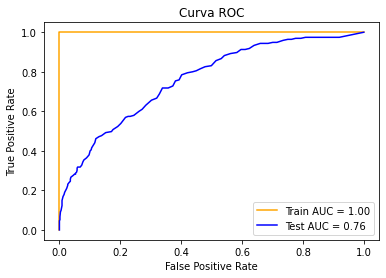

Parcelas con acierto:  30 de 39   76.92%
Exito min:  0.3305073683413035 
Exito max:  0.93 
Exito promedio:  0.6449586602801467
Exito * accuracy =  0.49942952667847257
Exito * accuracy / (Exito + accuracy) =  0.3518800263518593
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       585
           1       0.56      0.62      0.59       195

    accuracy                           0.78       780
   macro avg       0.71      0.73      0.72       780
weighted avg       0.79      0.78      0.79       780



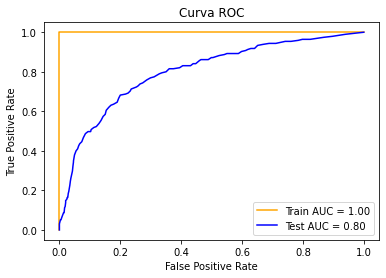

Parcelas con acierto:  36 de 39   92.31%
Exito min:  0.31141654656326895 
Exito max:  0.94 
Exito promedio:  0.6737485824044261
Exito * accuracy =  0.5277697228834671
Exito * accuracy / (Exito + accuracy) =  0.36221005640320725
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       585
           1       0.48      0.44      0.46       195

    accuracy                           0.74       780
   macro avg       0.65      0.64      0.65       780
weighted avg       0.73      0.74      0.74       780



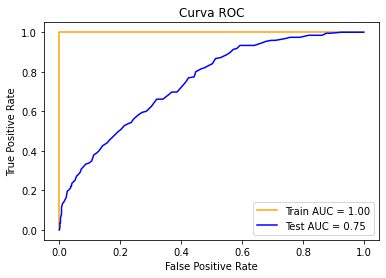

Parcelas con acierto:  32 de 39   82.05%
Exito min:  0.3 
Exito max:  0.96 
Exito promedio:  0.6070660339972169
Exito * accuracy =  0.4506297867748572
Exito * accuracy / (Exito + accuracy) =  0.33395476582225325
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       585
           1       0.44      0.39      0.41       195

    accuracy                           0.72       780
   macro avg       0.62      0.61      0.62       780
weighted avg       0.71      0.72      0.72       780



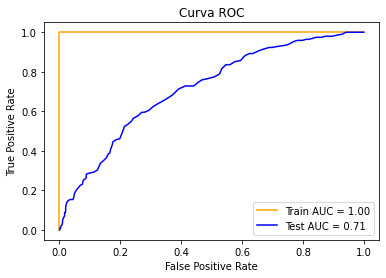

Parcelas con acierto:  29 de 39   74.36%
Exito min:  0.34 
Exito max:  0.99 
Exito promedio:  0.6205513012268364
Exito * accuracy =  0.44870632550248174
Exito * accuracy / (Exito + accuracy) =  0.33395125034307177
              precision    recall  f1-score   support

           0       0.85      0.84      0.84       570
           1       0.54      0.56      0.55       190

    accuracy                           0.77       760
   macro avg       0.69      0.70      0.70       760
weighted avg       0.77      0.77      0.77       760



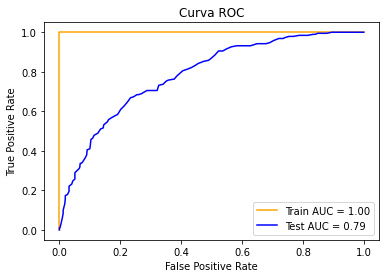

Parcelas con acierto:  34 de 38   89.47%
Exito min:  0.3058562117850746 
Exito max:  0.96 
Exito promedio:  0.7111054171209155
Exito * accuracy =  0.5464283731560718
Exito * accuracy / (Exito + accuracy) =  0.3693265273229496
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       570
           1       0.59      0.51      0.55       190

    accuracy                           0.79       760
   macro avg       0.72      0.70      0.71       760
weighted avg       0.78      0.79      0.78       760



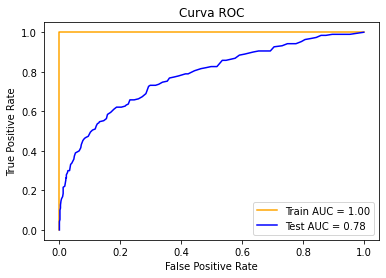

Parcelas con acierto:  28 de 38   73.68%
Exito min:  0.330824065808346 
Exito max:  0.99 
Exito promedio:  0.650145279892157
Exito * accuracy =  0.513272589388545
Exito * accuracy / (Exito + accuracy) =  0.356533639933306
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       570
           1       0.53      0.47      0.50       190

    accuracy                           0.76       760
   macro avg       0.68      0.66      0.67       760
weighted avg       0.75      0.76      0.76       760



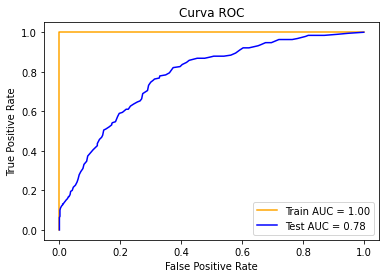

Parcelas con acierto:  29 de 38   76.32%
Exito min:  0.23058653605207222 
Exito max:  0.88 
Exito promedio:  0.5876708391883443
Exito * accuracy =  0.44848564043321015
Exito * accuracy / (Exito + accuracy) =  0.33200777357616446
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       570
           1       0.50      0.48      0.49       190

    accuracy                           0.75       760
   macro avg       0.66      0.66      0.66       760
weighted avg       0.75      0.75      0.75       760



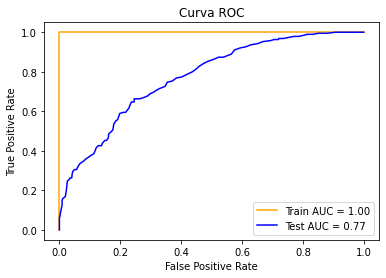

Parcelas con acierto:  31 de 38   81.58%
Exito min:  0.35880602104028814 
Exito max:  0.96 
Exito promedio:  0.6649443981735954
Exito * accuracy =  0.49870829863019656
Exito * accuracy / (Exito + accuracy) =  0.3524578769836661
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       570
           1       0.45      0.42      0.43       190

    accuracy                           0.73       760
   macro avg       0.63      0.62      0.63       760
weighted avg       0.72      0.73      0.72       760



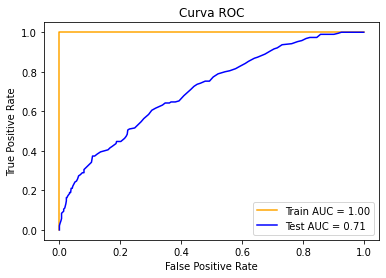

Parcelas con acierto:  28 de 38   73.68%
Exito min:  0.30931002066406627 
Exito max:  0.97 
Exito promedio:  0.6204854596527338
Exito * accuracy =  0.4523012429573876
Exito * accuracy / (Exito + accuracy) =  0.33517877551786956
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       570
           1       0.56      0.37      0.45       190

    accuracy                           0.77       760
   macro avg       0.69      0.64      0.65       760
weighted avg       0.75      0.77      0.75       760



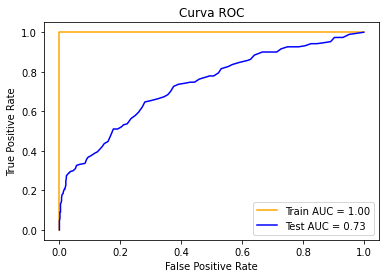

Parcelas con acierto:  25 de 38   65.79%
Exito min:  0.22471068620944254 
Exito max:  0.95 
Exito promedio:  0.5695624287645954
Exito * accuracy =  0.439162609547438
Exito * accuracy / (Exito + accuracy) =  0.32758293005816247


In [73]:
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[0,1], 
                                   algoritmo=RandomForestRegressor, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10
                                  )

- Con normalizacion entre 0 y 1 y umbral de 0.6:
  - El maximo accuracy obtenido es de 0.79, el cual no mejora el de entrenamientos con red neuronal de anteriores pruebas, el cual era 0.8 o 0.82 (no me acuerdo ahora mismo).
  - El maximo de parcelas ha sido 36/38 (92%) con un exito de 0.6737485824044261
  - Los mayores exitos han sido de 0.7111054171209155 en una prueba que ha acertado 34/38 parcelas (89%). Resultado muy bueno (el mejor hasta ahora).
- Con normalizacion entre -1 y 1 y umbral de 0.6:
  - El maximo accuracy obtenido es de 0.79, el cual no mejora el de entrenamientos con red neuronal de anteriores pruebas, el cual era 0.8.
  - El maximo de parcelas ha sido 36/38 (92%) con un exito de 0.6815129023226598
  - Los mayores exitos han sido de 0.6905605826542855en una prueba que acierta 33/38 (86%) parcelas

El accuracy global ha sido igual en ambas pruebas, pero el de normalizacion [0,1] ha tenido mejores exitos

Prueba con SVC:

              precision    recall  f1-score   support

           0       0.87      0.36      0.51       585
           1       0.30      0.84      0.45       195

    accuracy                           0.48       780
   macro avg       0.59      0.60      0.48       780
weighted avg       0.73      0.48      0.49       780



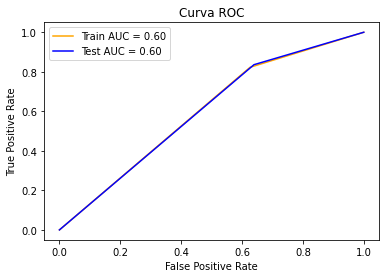

Parcelas con acierto:  36 de 39   92.31%
Exito min:  0 
Exito max:  1 
Exito promedio:  0.9136459611718902
Exito * accuracy =  0.4380815249721628
Exito * accuracy / (Exito + accuracy) =  0.31445775869269266
              precision    recall  f1-score   support

           0       0.79      0.43      0.56       585
           1       0.28      0.66      0.39       195

    accuracy                           0.49       780
   macro avg       0.54      0.55      0.48       780
weighted avg       0.66      0.49      0.52       780



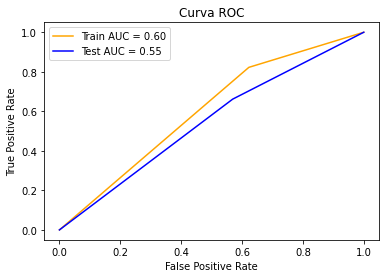

Parcelas con acierto:  32 de 39   82.05%
Exito min:  0 
Exito max:  1 
Exito promedio:  0.8786385781848659
Exito * accuracy =  0.42918115165183834
Exito * accuracy / (Exito + accuracy) =  0.3139354217192599
              precision    recall  f1-score   support

           0       0.78      0.33      0.46       585
           1       0.27      0.73      0.39       195

    accuracy                           0.43       780
   macro avg       0.52      0.53      0.43       780
weighted avg       0.65      0.43      0.44       780



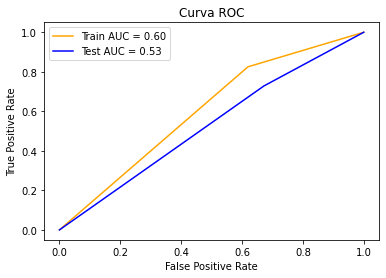

Parcelas con acierto:  34 de 39   87.18%
Exito min:  0 
Exito max:  1 
Exito promedio:  0.8677720239538772
Exito * accuracy =  0.37158443076999353
Exito * accuracy / (Exito + accuracy) =  0.2867214365245255
              precision    recall  f1-score   support

           0       0.88      0.36      0.51       585
           1       0.31      0.86      0.45       195

    accuracy                           0.48       780
   macro avg       0.60      0.61      0.48       780
weighted avg       0.74      0.48      0.50       780



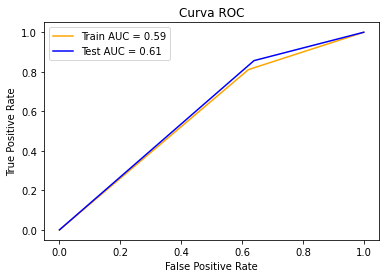

Parcelas con acierto:  37 de 39   94.87%
Exito min:  0.5623818557528477 
Exito max:  1 
Exito promedio:  0.9663645471666951
Exito * accuracy =  0.46831512670385994
Exito * accuracy / (Exito + accuracy) =  0.3227578248643865
              precision    recall  f1-score   support

           0       0.87      0.32      0.47       570
           1       0.30      0.86      0.44       190

    accuracy                           0.45       760
   macro avg       0.58      0.59      0.45       760
weighted avg       0.73      0.45      0.46       760



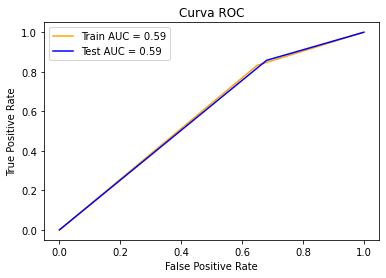

Parcelas con acierto:  36 de 38   94.74%
Exito min:  0.4659554245485505 
Exito max:  1 
Exito promedio:  0.9652681971252073
Exito * accuracy =  0.43818095790552175
Exito * accuracy / (Exito + accuracy) =  0.3087486979026084
              precision    recall  f1-score   support

           0       0.81      0.32      0.46       570
           1       0.27      0.77      0.40       190

    accuracy                           0.43       760
   macro avg       0.54      0.54      0.43       760
weighted avg       0.67      0.43      0.45       760



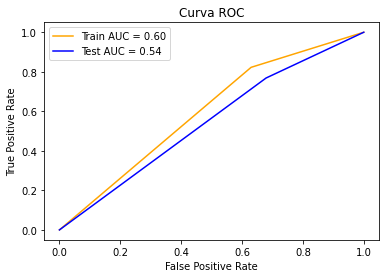

Parcelas con acierto:  34 de 38   89.47%
Exito min:  0 
Exito max:  1 
Exito promedio:  0.9177100069203917
Exito * accuracy =  0.3972718319431696
Exito * accuracy / (Exito + accuracy) =  0.2941436669594799
              precision    recall  f1-score   support

           0       0.86      0.37      0.52       570
           1       0.30      0.83      0.44       190

    accuracy                           0.48       760
   macro avg       0.58      0.60      0.48       760
weighted avg       0.72      0.48      0.50       760



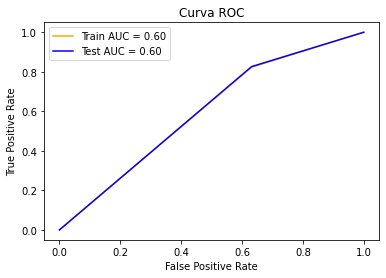

Parcelas con acierto:  34 de 38   89.47%
Exito min:  0 
Exito max:  1 
Exito promedio:  0.9193367041527319
Exito * accuracy =  0.44394285582112186
Exito * accuracy / (Exito + accuracy) =  0.316597419543067
              precision    recall  f1-score   support

           0       0.84      0.45      0.58       570
           1       0.31      0.75      0.44       190

    accuracy                           0.52       760
   macro avg       0.58      0.60      0.51       760
weighted avg       0.71      0.52      0.55       760



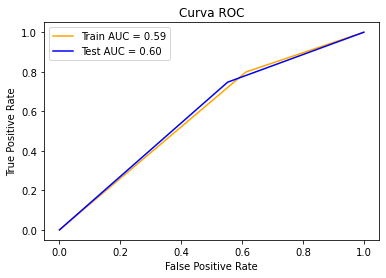

Parcelas con acierto:  37 de 38   97.37%
Exito min:  0 
Exito max:  1 
Exito promedio:  0.949205542893444
Exito * accuracy =  0.49583500069565434
Exito * accuracy / (Exito + accuracy) =  0.33694194980594516
              precision    recall  f1-score   support

           0       0.81      0.46      0.58       570
           1       0.29      0.68      0.41       190

    accuracy                           0.51       760
   macro avg       0.55      0.57      0.50       760
weighted avg       0.68      0.51      0.54       760



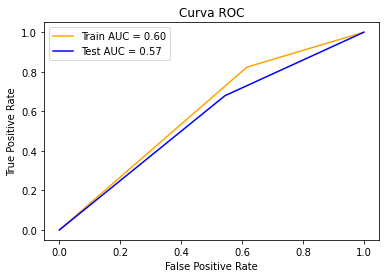

Parcelas con acierto:  29 de 38   76.32%
Exito min:  0 
Exito max:  1 
Exito promedio:  0.809211364061317
Exito * accuracy =  0.4141884481840162
Exito * accuracy / (Exito + accuracy) =  0.3135289053786845
              precision    recall  f1-score   support

           0       0.82      0.36      0.50       570
           1       0.29      0.77      0.42       190

    accuracy                           0.46       760
   macro avg       0.55      0.56      0.46       760
weighted avg       0.69      0.46      0.48       760



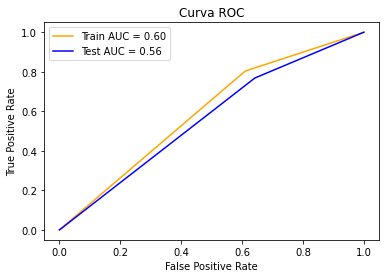

Parcelas con acierto:  33 de 38   86.84%
Exito min:  0 
Exito max:  1 
Exito promedio:  0.8726694716911123
Exito * accuracy =  0.40188725669985437
Exito * accuracy / (Exito + accuracy) =  0.3014465395658975


In [32]:
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[0,1], 
                                   algoritmo=SVC, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10
                                  )

#SVC(), GaussianNB(), KNeighborsClassifier(), 
 #         GradientBoostingClassifier(), AdaBoostClassifier(), MLPClassifier()

Da porcentajes de acierto de parcelas muy altos y exitos muy altos ya que tiende a etiquetar todo como 1. Por esto la precision es tan baja y no me vale como buen resultado. He creado 2 metricas nuevas para reducir el exito en estos casos.

Prueba con GradientBoostingClassifier:

              precision    recall  f1-score   support

           0       0.80      0.89      0.84       585
           1       0.48      0.32      0.38       195

    accuracy                           0.74       780
   macro avg       0.64      0.60      0.61       780
weighted avg       0.72      0.74      0.72       780



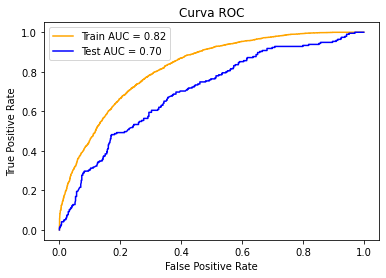

Parcelas con acierto:  26 de 39   66.67%
Exito min:  0.3246228029240595 
Exito max:  0.7173952657651319 
Exito promedio:  0.5511486665736698
Exito * accuracy =  0.4098284956573442
Exito * accuracy / (Exito + accuracy) =  0.31653382060830215
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       585
           1       0.46      0.40      0.43       195

    accuracy                           0.73       780
   macro avg       0.63      0.62      0.63       780
weighted avg       0.72      0.73      0.72       780



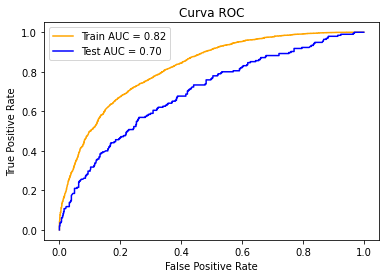

Parcelas con acierto:  24 de 39   61.54%
Exito min:  0.2209591880889705 
Exito max:  0.7837784064408341 
Exito promedio:  0.5565339616135235
Exito * accuracy =  0.40669789502526715
Exito * accuracy / (Exito + accuracy) =  0.31593015338716224
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       585
           1       0.50      0.39      0.44       195

    accuracy                           0.75       780
   macro avg       0.66      0.63      0.64       780
weighted avg       0.73      0.75      0.74       780



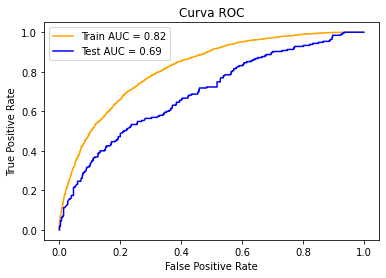

Parcelas con acierto:  24 de 39   61.54%
Exito min:  0.3033214931016245 
Exito max:  0.7325474741580371 
Exito promedio:  0.546060178150689
Exito * accuracy =  0.4095451336130167
Exito * accuracy / (Exito + accuracy) =  0.3159923748273671
              precision    recall  f1-score   support

           0       0.79      0.85      0.82       585
           1       0.43      0.34      0.38       195

    accuracy                           0.72       780
   macro avg       0.61      0.60      0.60       780
weighted avg       0.70      0.72      0.71       780



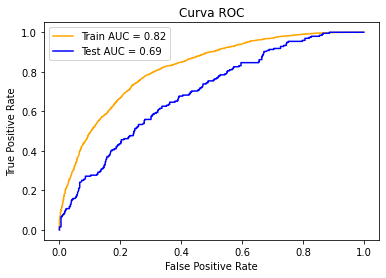

Parcelas con acierto:  24 de 39   61.54%
Exito min:  0.36613365424840555 
Exito max:  0.7551991081977267 
Exito promedio:  0.5621827991188632
Exito * accuracy =  0.40578066141528196
Exito * accuracy / (Exito + accuracy) =  0.31603404841652005
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       570
           1       0.52      0.43      0.47       190

    accuracy                           0.76       760
   macro avg       0.67      0.65      0.66       760
weighted avg       0.74      0.76      0.75       760



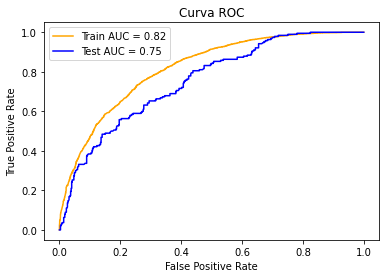

Parcelas con acierto:  28 de 38   73.68%
Exito min:  0.3911204650943797 
Exito max:  0.8174438451449656 
Exito promedio:  0.597807498124838
Exito * accuracy =  0.4522885676602393
Exito * accuracy / (Exito + accuracy) =  0.33394351306839803
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       570
           1       0.48      0.37      0.42       190

    accuracy                           0.74       760
   macro avg       0.64      0.62      0.63       760
weighted avg       0.72      0.74      0.73       760



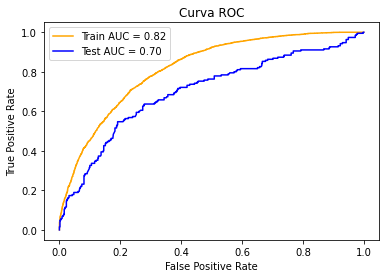

Parcelas con acierto:  26 de 38   68.42%
Exito min:  0.31514670691953334 
Exito max:  0.7934654468755694 
Exito promedio:  0.5661341386866691
Exito * accuracy =  0.4201311239727386
Exito * accuracy / (Exito + accuracy) =  0.3211423867683323
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       570
           1       0.45      0.25      0.32       190

    accuracy                           0.74       760
   macro avg       0.62      0.58      0.58       760
weighted avg       0.70      0.74      0.71       760



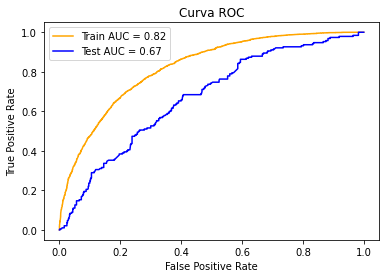

Parcelas con acierto:  22 de 38   57.89%
Exito min:  0.34843852605707176 
Exito max:  0.7352285925090538 
Exito promedio:  0.5481024384774461
Exito * accuracy =  0.40386495466759187
Exito * accuracy / (Exito + accuracy) =  0.3143053578731888
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       570
           1       0.50      0.36      0.42       190

    accuracy                           0.75       760
   macro avg       0.65      0.62      0.63       760
weighted avg       0.73      0.75      0.73       760



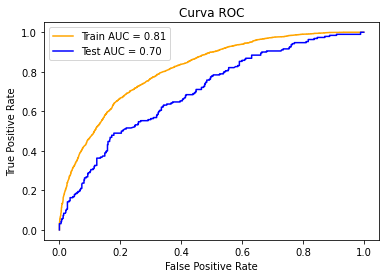

Parcelas con acierto:  26 de 38   68.42%
Exito min:  0.2929873859684518 
Exito max:  0.7841000041800262 
Exito promedio:  0.5551505915545567
Exito * accuracy =  0.4156324823612405
Exito * accuracy / (Exito + accuracy) =  0.3187769506519586
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       570
           1       0.40      0.26      0.31       190

    accuracy                           0.72       760
   macro avg       0.59      0.56      0.57       760
weighted avg       0.68      0.72      0.70       760



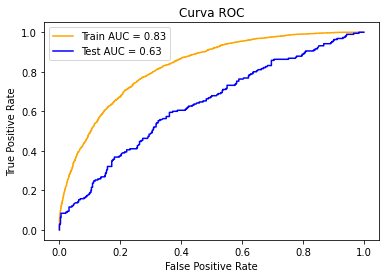

Parcelas con acierto:  18 de 38   47.37%
Exito min:  0.2237801075119505 
Exito max:  0.8186385774622739 
Exito promedio:  0.5175349195035529
Exito * accuracy =  0.37180798164334194
Exito * accuracy / (Exito + accuracy) =  0.30082623493540656
              precision    recall  f1-score   support

           0       0.81      0.92      0.86       570
           1       0.58      0.34      0.43       190

    accuracy                           0.77       760
   macro avg       0.69      0.63      0.64       760
weighted avg       0.75      0.77      0.75       760



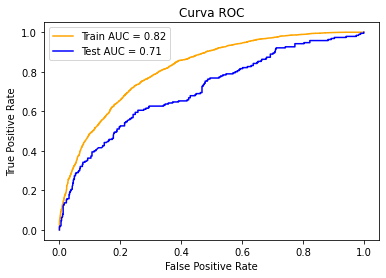

Parcelas con acierto:  24 de 38   63.16%
Exito min:  0.2549849472306347 
Exito max:  0.7948370476227554 
Exito promedio:  0.5600093270966551
Exito * accuracy =  0.4332703741221489
Exito * accuracy / (Exito + accuracy) =  0.3248650172620335


In [33]:
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[0,1], 
                                   algoritmo=GradientBoostingClassifier, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10
                                  )

Parecido a RandomForest pero con peor accuracy, porcentaje de parcelas acertadas y exito.

Prueba con AdaBoostClassifier:

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       585
           1       0.00      0.00      0.00       195

    accuracy                           0.75       780
   macro avg       0.38      0.50      0.43       780
weighted avg       0.56      0.75      0.64       780



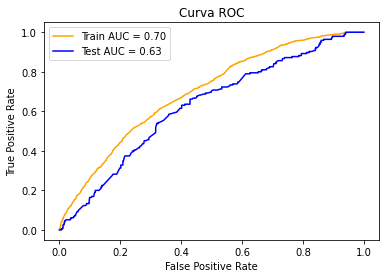

Parcelas con acierto:  0 de 39   0.00%
Exito min:  0.49494099676579956 
Exito max:  0.5059890075436906 
Exito promedio:  0.500942400010212
Exito * accuracy =  0.375706800007659
Exito * accuracy / (Exito + accuracy) =  0.30033900841844674
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       585
           1       0.00      0.00      0.00       195

    accuracy                           0.75       780
   macro avg       0.38      0.50      0.43       780
weighted avg       0.56      0.75      0.64       780



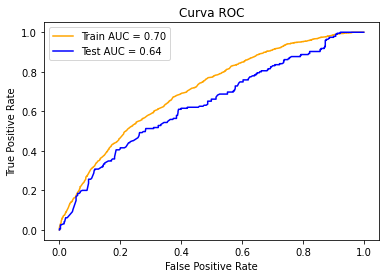

Parcelas con acierto:  0 de 39   0.00%
Exito min:  0.49133984460800806 
Exito max:  0.5055022209947003 
Exito promedio:  0.5008396934786915
Exito * accuracy =  0.37562977010901866
Exito * accuracy / (Exito + accuracy) =  0.30030208672412717
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       585
           1       0.00      0.00      0.00       195

    accuracy                           0.75       780
   macro avg       0.38      0.50      0.43       780
weighted avg       0.56      0.75      0.64       780



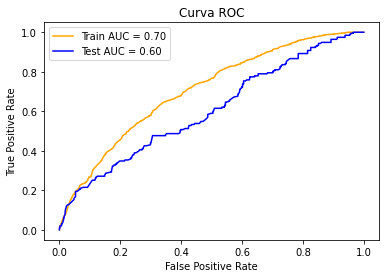

Parcelas con acierto:  0 de 39   0.00%
Exito min:  0.49431207275690037 
Exito max:  0.5046676520786681 
Exito promedio:  0.5005826724265161
Exito * accuracy =  0.3754370043198871
Exito * accuracy / (Exito + accuracy) =  0.3002096643410415
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       585
           1       0.00      0.00      0.00       195

    accuracy                           0.75       780
   macro avg       0.38      0.50      0.43       780
weighted avg       0.56      0.75      0.64       780



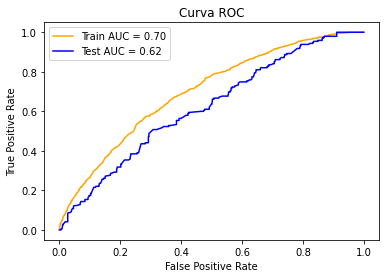

Parcelas con acierto:  0 de 39   0.00%
Exito min:  0.4960850447238797 
Exito max:  0.5053419702891885 
Exito promedio:  0.5010636407403154
Exito * accuracy =  0.3757977305552366
Exito * accuracy / (Exito + accuracy) =  0.30038258512001736
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       570
           1       0.00      0.00      0.00       190

    accuracy                           0.75       760
   macro avg       0.38      0.50      0.43       760
weighted avg       0.56      0.75      0.64       760



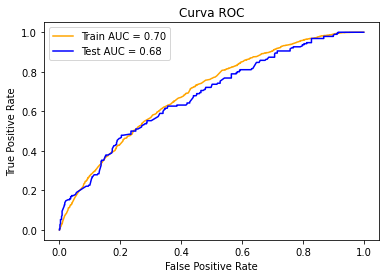

Parcelas con acierto:  0 de 38   0.00%
Exito min:  0.49588434889970245 
Exito max:  0.5061816337896906 
Exito promedio:  0.5014016194867555
Exito * accuracy =  0.37605121461506663
Exito * accuracy / (Exito + accuracy) =  0.300504017862226
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       570
           1       0.00      0.00      0.00       190

    accuracy                           0.75       760
   macro avg       0.38      0.50      0.43       760
weighted avg       0.56      0.75      0.64       760



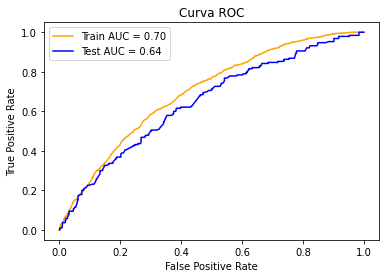

Parcelas con acierto:  0 de 38   0.00%
Exito min:  0.38258544330888916 
Exito max:  0.505679659471907 
Exito promedio:  0.4981782442224454
Exito * accuracy =  0.37363368316683404
Exito * accuracy / (Exito + accuracy) =  0.29934321071233677
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       570
           1       0.00      0.00      0.00       190

    accuracy                           0.75       760
   macro avg       0.38      0.50      0.43       760
weighted avg       0.56      0.75      0.64       760



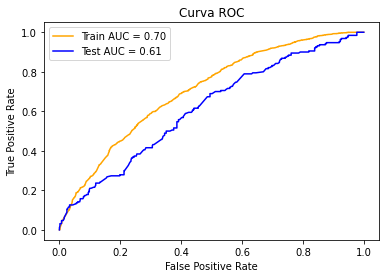

Parcelas con acierto:  0 de 38   0.00%
Exito min:  0.4821828974972751 
Exito max:  0.505920495948522 
Exito promedio:  0.5004329049308227
Exito * accuracy =  0.37532467869811703
Exito * accuracy / (Exito + accuracy) =  0.3001557918206583
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       570
           1       0.00      0.00      0.00       190

    accuracy                           0.75       760
   macro avg       0.38      0.50      0.43       760
weighted avg       0.56      0.75      0.64       760



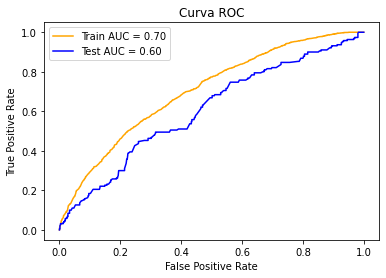

Parcelas con acierto:  0 de 38   0.00%
Exito min:  0.3190605755085343 
Exito max:  0.5084522978275265 
Exito promedio:  0.49663591031280485
Exito * accuracy =  0.37247693273460364
Exito * accuracy / (Exito + accuracy) =  0.29878565959257664
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       570
           1       0.00      0.00      0.00       190

    accuracy                           0.75       760
   macro avg       0.38      0.50      0.43       760
weighted avg       0.56      0.75      0.64       760



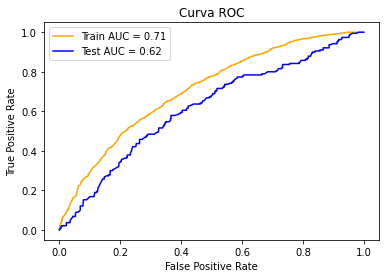

Parcelas con acierto:  0 de 38   0.00%
Exito min:  0.32784006270968274 
Exito max:  0.515166628039779 
Exito promedio:  0.49614046876899226
Exito * accuracy =  0.3721053515767442
Exito * accuracy / (Exito + accuracy) =  0.29860626542714785
              precision    recall  f1-score   support

           0       0.75      1.00      0.86       570
           1       0.00      0.00      0.00       190

    accuracy                           0.75       760
   macro avg       0.38      0.50      0.43       760
weighted avg       0.56      0.75      0.64       760



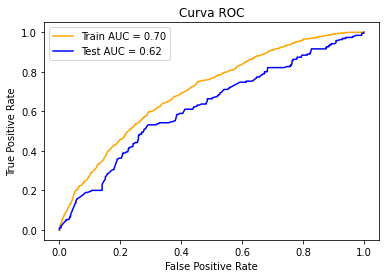

Parcelas con acierto:  0 de 38   0.00%
Exito min:  0.31806985703726864 
Exito max:  0.5045995255956595 
Exito promedio:  0.49615143171807147
Exito * accuracy =  0.3721135737885536
Exito * accuracy / (Exito + accuracy) =  0.29861023653884494


In [37]:
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[0,1], 
                                   algoritmo=AdaBoostClassifier, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10
                                  )

Malos resultados. Etiqueta todo a cero.

Prueba con MLPClassifier:

              precision    recall  f1-score   support

           0       0.80      0.79      0.80       585
           1       0.39      0.40      0.40       195

    accuracy                           0.69       780
   macro avg       0.60      0.60      0.60       780
weighted avg       0.70      0.69      0.70       780



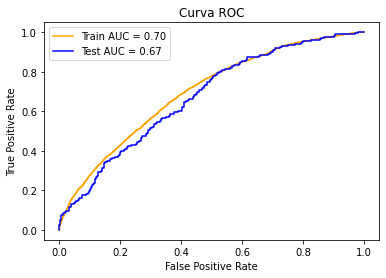

Parcelas con acierto:  24 de 39   61.54%
Exito min:  0.38908810608589106 
Exito max:  0.8614307524245045 
Exito promedio:  0.5991055897520923
Exito * accuracy =  0.41630157646876154
Exito * accuracy / (Exito + accuracy) =  0.3217224515788315
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       585
           1       0.40      0.33      0.36       195

    accuracy                           0.71       780
   macro avg       0.59      0.58      0.59       780
weighted avg       0.69      0.71      0.70       780



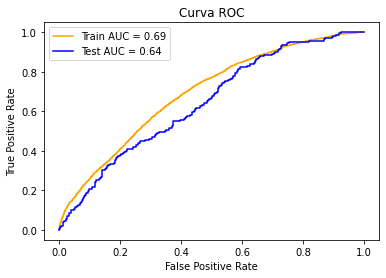

Parcelas con acierto:  21 de 39   53.85%
Exito min:  0.1844171558085814 
Exito max:  0.7451080543626879 
Exito promedio:  0.5571013060295644
Exito * accuracy =  0.394256308882461
Exito * accuracy / (Exito + accuracy) =  0.3117159231396609
              precision    recall  f1-score   support

           0       0.77      0.79      0.78       585
           1       0.32      0.30      0.31       195

    accuracy                           0.67       780
   macro avg       0.55      0.55      0.55       780
weighted avg       0.66      0.67      0.66       780



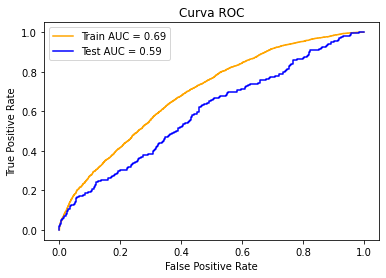

Parcelas con acierto:  20 de 39   51.28%
Exito min:  0.34618233035919893 
Exito max:  0.8549156950407154 
Exito promedio:  0.5649741757978699
Exito * accuracy =  0.37737377639832076
Exito * accuracy / (Exito + accuracy) =  0.30608059783168023
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       585
           1       0.38      0.34      0.36       195

    accuracy                           0.69       780
   macro avg       0.58      0.58      0.58       780
weighted avg       0.68      0.69      0.69       780



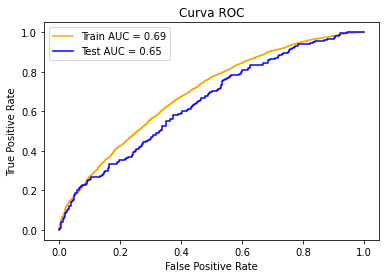

Parcelas con acierto:  22 de 39   56.41%
Exito min:  0.3334520631606628 
Exito max:  0.7863990681543113 
Exito promedio:  0.5776493762328386
Exito * accuracy =  0.40065168274610985
Exito * accuracy / (Exito + accuracy) =  0.31516626297814526
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       570
           1       0.37      0.47      0.41       190

    accuracy                           0.67       760
   macro avg       0.59      0.60      0.59       760
weighted avg       0.70      0.67      0.68       760



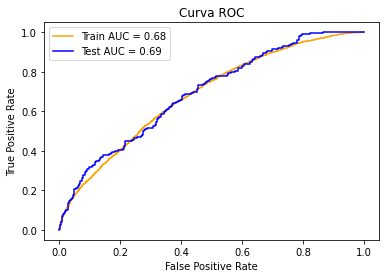

Parcelas con acierto:  26 de 38   68.42%
Exito min:  0.3917851154142385 
Exito max:  0.7652136830362402 
Exito promedio:  0.5972736494124089
Exito * accuracy =  0.39923028144934697
Exito * accuracy / (Exito + accuracy) =  0.3154238386276126
              precision    recall  f1-score   support

           0       0.79      0.80      0.80       570
           1       0.38      0.36      0.37       190

    accuracy                           0.69       760
   macro avg       0.58      0.58      0.58       760
weighted avg       0.69      0.69      0.69       760



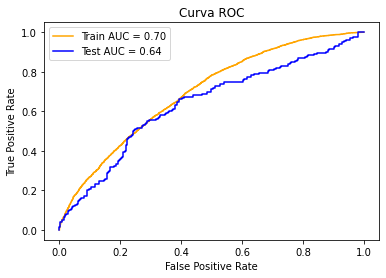

Parcelas con acierto:  27 de 38   71.05%
Exito min:  0.31930130668107387 
Exito max:  0.8367085471654152 
Exito promedio:  0.5889691349575781
Exito * accuracy =  0.40685367875359013
Exito * accuracy / (Exito + accuracy) =  0.31791439104706243
              precision    recall  f1-score   support

           0       0.78      0.81      0.79       570
           1       0.34      0.30      0.32       190

    accuracy                           0.68       760
   macro avg       0.56      0.55      0.55       760
weighted avg       0.67      0.68      0.67       760



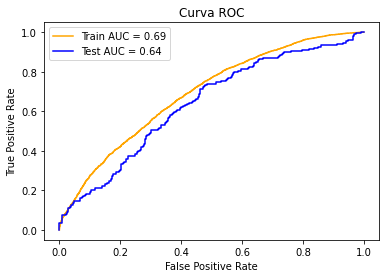

Parcelas con acierto:  19 de 38   50.00%
Exito min:  0.25533211130201866 
Exito max:  0.8749860476228923 
Exito promedio:  0.5798730591765089
Exito * accuracy =  0.393703287546156
Exito * accuracy / (Exito + accuracy) =  0.31275571869891916
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       570
           1       0.35      0.40      0.38       190

    accuracy                           0.67       760
   macro avg       0.57      0.58      0.57       760
weighted avg       0.68      0.67      0.67       760



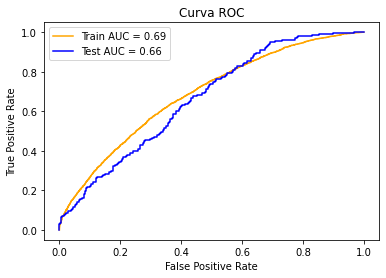

Parcelas con acierto:  26 de 38   68.42%
Exito min:  0.43113719751764207 
Exito max:  0.8065420836735359 
Exito promedio:  0.5892843920909268
Exito * accuracy =  0.39311471946065774
Exito * accuracy / (Exito + accuracy) =  0.31289235613994565
              precision    recall  f1-score   support

           0       0.77      0.81      0.78       570
           1       0.31      0.26      0.28       190

    accuracy                           0.67       760
   macro avg       0.54      0.53      0.53       760
weighted avg       0.65      0.67      0.66       760



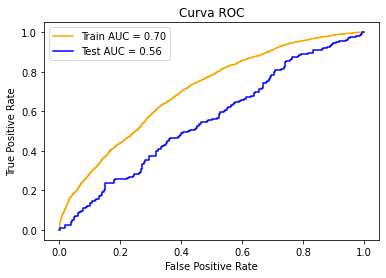

Parcelas con acierto:  18 de 38   47.37%
Exito min:  0.33818659712928006 
Exito max:  0.8330745392101436 
Exito promedio:  0.5449699649329158
Exito * accuracy =  0.36426939761305427
Exito * accuracy / (Exito + accuracy) =  0.3002077585378964
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       570
           1       0.38      0.29      0.33       190

    accuracy                           0.71       760
   macro avg       0.58      0.57      0.57       760
weighted avg       0.68      0.71      0.69       760



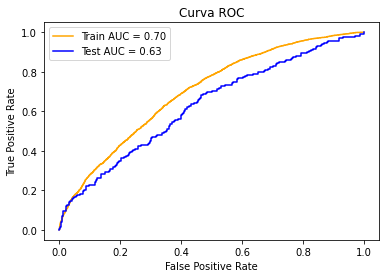

Parcelas con acierto:  20 de 38   52.63%
Exito min:  0.29456382166650974 
Exito max:  0.76143343097466 
Exito promedio:  0.5647383452940296
Exito * accuracy =  0.39828914878631555
Exito * accuracy / (Exito + accuracy) =  0.3136131317847078


In [38]:
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[0,1], 
                                   algoritmo=MLPClassifier, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10
                                  )


Similar a AdaBoostClassifier pero peor.

Pruebo con la version scikit-learn de XGBoost:

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       585
           1       0.52      0.51      0.52       195

    accuracy                           0.76       780
   macro avg       0.68      0.68      0.68       780
weighted avg       0.76      0.76      0.76       780



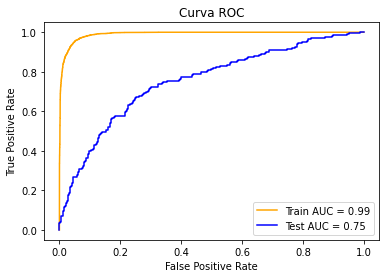

Parcelas con acierto:  35 de 39   89.74%
Exito min:  0.2764317 
Exito max:  0.93378043 
Exito promedio:  0.6636201523749706
Exito * accuracy =  0.5053722698855545
Exito * accuracy / (Exito + accuracy) =  0.35460773625598146
              precision    recall  f1-score   support

           0       0.85      0.83      0.84       585
           1       0.53      0.58      0.55       195

    accuracy                           0.76       780
   macro avg       0.69      0.70      0.70       780
weighted avg       0.77      0.76      0.77       780



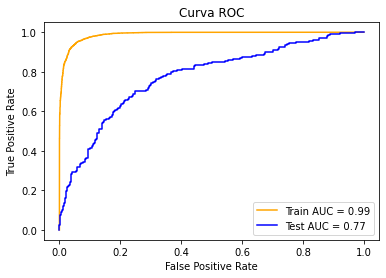

Parcelas con acierto:  36 de 39   92.31%
Exito min:  0.29027334826247986 
Exito max:  0.9420873 
Exito promedio:  0.6777686835658444
Exito * accuracy =  0.517884788981081
Exito * accuracy / (Exito + accuracy) =  0.35917547410597966
              precision    recall  f1-score   support

           0       0.83      0.88      0.85       585
           1       0.55      0.45      0.49       195

    accuracy                           0.77       780
   macro avg       0.69      0.66      0.67       780
weighted avg       0.76      0.77      0.76       780



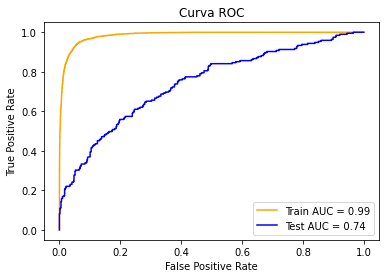

Parcelas con acierto:  33 de 39   84.62%
Exito min:  0.2522891596017723 
Exito max:  0.97721136 
Exito promedio:  0.6499326646247175
Exito * accuracy =  0.49994820355747505
Exito * accuracy / (Exito + accuracy) =  0.3522837409918671
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       585
           1       0.50      0.50      0.50       195

    accuracy                           0.75       780
   macro avg       0.66      0.66      0.66       780
weighted avg       0.75      0.75      0.75       780



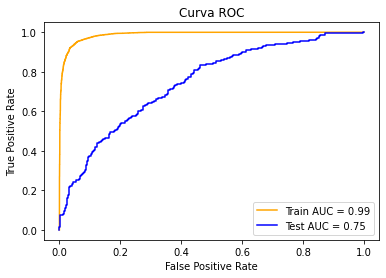

Parcelas con acierto:  35 de 39   89.74%
Exito min:  0.3845724397480676 
Exito max:  0.9871838 
Exito promedio:  0.6565333988379805
Exito * accuracy =  0.4915583396427956
Exito * accuracy / (Exito + accuracy) =  0.3498010092626732
              precision    recall  f1-score   support

           0       0.85      0.82      0.84       570
           1       0.52      0.58      0.55       190

    accuracy                           0.76       760
   macro avg       0.69      0.70      0.69       760
weighted avg       0.77      0.76      0.76       760



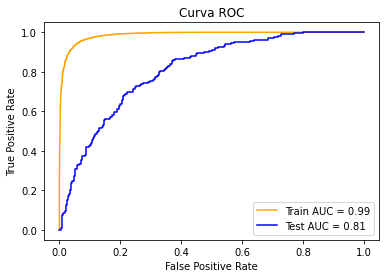

Parcelas con acierto:  34 de 38   89.47%
Exito min:  0.40995213 
Exito max:  0.97417575 
Exito promedio:  0.7335090121799802
Exito * accuracy =  0.5578529066316166
Exito * accuracy / (Exito + accuracy) =  0.37338669052076257
              precision    recall  f1-score   support

           0       0.86      0.87      0.87       570
           1       0.60      0.58      0.59       190

    accuracy                           0.80       760
   macro avg       0.73      0.73      0.73       760
weighted avg       0.80      0.80      0.80       760



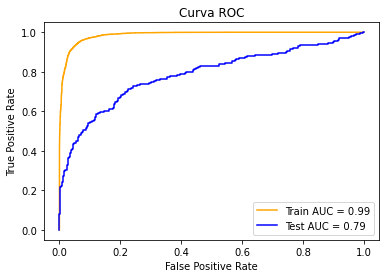

Parcelas con acierto:  32 de 38   84.21%
Exito min:  0.3568570469259502 
Exito max:  0.9686442 
Exito promedio:  0.6971048852510344
Exito * accuracy =  0.5576839082008276
Exito * accuracy / (Exito + accuracy) =  0.3725082415366744
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       570
           1       0.50      0.49      0.50       190

    accuracy                           0.75       760
   macro avg       0.67      0.66      0.67       760
weighted avg       0.75      0.75      0.75       760



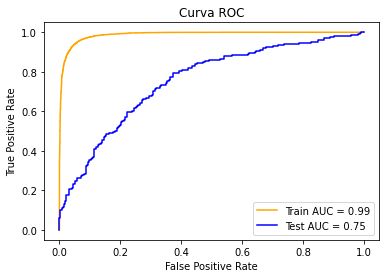

Parcelas con acierto:  29 de 38   76.32%
Exito min:  0.23358540883275059 
Exito max:  0.94996434 
Exito promedio:  0.6264565391114402
Exito * accuracy =  0.47066668925346355
Exito * accuracy / (Exito + accuracy) =  0.34161427072410816
              precision    recall  f1-score   support

           0       0.85      0.85      0.85       570
           1       0.54      0.54      0.54       190

    accuracy                           0.77       760
   macro avg       0.69      0.69      0.69       760
weighted avg       0.77      0.77      0.77       760



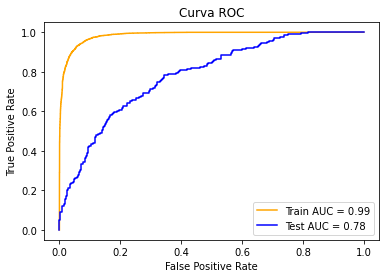

Parcelas con acierto:  34 de 38   89.47%
Exito min:  0.25201967258641217 
Exito max:  0.9708685 
Exito promedio:  0.6548468568520395
Exito * accuracy =  0.5040597516558462
Exito * accuracy / (Exito + accuracy) =  0.35382950964887727
              precision    recall  f1-score   support

           0       0.83      0.84      0.83       570
           1       0.50      0.49      0.49       190

    accuracy                           0.75       760
   macro avg       0.66      0.66      0.66       760
weighted avg       0.75      0.75      0.75       760



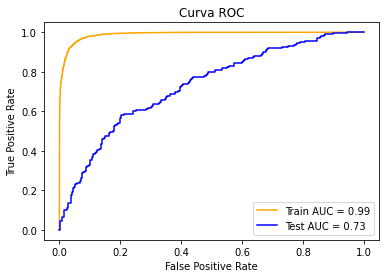

Parcelas con acierto:  33 de 38   86.84%
Exito min:  0.27290633557825067 
Exito max:  0.9676962 
Exito promedio:  0.6422493041915761
Exito * accuracy =  0.48084191326974585
Exito * accuracy / (Exito + accuracy) =  0.34569726603163337
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       570
           1       0.51      0.46      0.48       190

    accuracy                           0.75       760
   macro avg       0.67      0.66      0.66       760
weighted avg       0.75      0.75      0.75       760



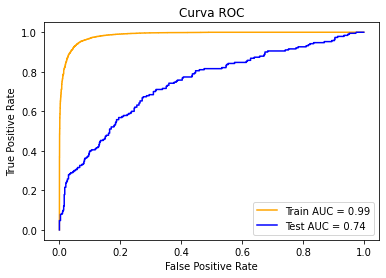

Parcelas con acierto:  32 de 38   84.21%
Exito min:  0.30866781832236045 
Exito max:  0.9639891 
Exito promedio:  0.6241741628803992
Exito * accuracy =  0.4705944675400904
Exito * accuracy / (Exito + accuracy) =  0.34147530304941737


In [10]:
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[0,1], 
                                   algoritmo=XGBClassifier, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10
                                  )


- Con normalizacion entre 0 y 1 y umbral de 0.6:
  - Hay un modelo con accuracy de 0.8. Este modelo tiene buenos valores de precision y recall tanto para la clase 1 como para la 0. Acierto 32/38 (84%) de las parcelas y tiene un exito de 0.69 (El segundo mejor hasta ahora).
  - El maximo de parcelas ha sido 36/38 (92%) con un exito de 0.6777686835658444 (El tercero mejor hasta ahora). Tiene buenos valores de precision y recall, aunque no llegan al nivel del del punto de encima.
  - El mayor exito es 0.7335090121799802, pero con un accuracy de 0.76 y acertando 34/38 (89%). Con la nueva metrica de Exito*accuracy, ambos modelos (el de mejor accuracy y este) tendrian un valor de 0.55.
- Con normalizacion entre -1 y 1 y umbral de 0.6:
  - hay un modelo que supera el 0.8 de accuracy (0.81) el cual acierta 32/38 (84%) parcelas y tiene un exito de 0.6862738732516765. Ademas tiene muy buenos valores de precision y recall para ambas clases. (Me gusta este resultado)
  - El maximo de parcelas ha sido 35/38 (92%) con un exito de 0.7328198949591411 (muy alto el score), y ademas con un accuracy de 0.8 sea seguramente el mejor modelo respecto a la metrica Exito*accuracy
  - El mayor exito ha sido 0.7328198949591411 en la prueba del punto superior.

Pruebo con la version scikit-learn de LGBM:

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       585
           1       0.49      0.46      0.47       195

    accuracy                           0.75       780
   macro avg       0.66      0.65      0.65       780
weighted avg       0.74      0.75      0.74       780



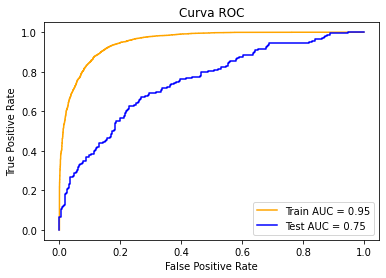

Parcelas con acierto:  30 de 39   76.92%
Exito min:  0.2780436650657917 
Exito max:  0.8341602457187323 
Exito promedio:  0.6234541248167235
Exito * accuracy =  0.4651926931324783
Exito * accuracy / (Exito + accuracy) =  0.33965390315509086
              precision    recall  f1-score   support

           0       0.86      0.86      0.86       585
           1       0.58      0.58      0.58       195

    accuracy                           0.79       780
   macro avg       0.72      0.72      0.72       780
weighted avg       0.79      0.79      0.79       780



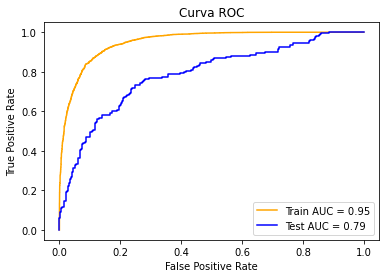

Parcelas con acierto:  34 de 39   87.18%
Exito min:  0.29764554491347966 
Exito max:  0.9169521357858474 
Exito promedio:  0.6241482534973377
Exito * accuracy =  0.4929170822491795
Exito * accuracy / (Exito + accuracy) =  0.3486243198909143
              precision    recall  f1-score   support

           0       0.82      0.87      0.84       585
           1       0.52      0.43      0.47       195

    accuracy                           0.76       780
   macro avg       0.67      0.65      0.66       780
weighted avg       0.75      0.76      0.75       780



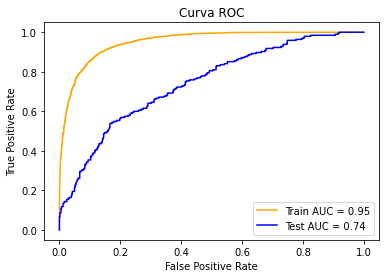

Parcelas con acierto:  31 de 39   79.49%
Exito min:  0.27996471709734994 
Exito max:  0.872611590535362 
Exito promedio:  0.6117952077336751
Exito * accuracy =  0.4643368756132508
Exito * accuracy / (Exito + accuracy) =  0.33874174543309793
              precision    recall  f1-score   support

           0       0.82      0.84      0.83       585
           1       0.49      0.45      0.47       195

    accuracy                           0.75       780
   macro avg       0.66      0.65      0.65       780
weighted avg       0.74      0.75      0.74       780



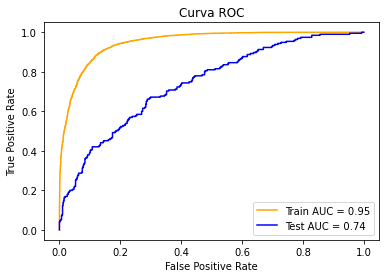

Parcelas con acierto:  31 de 39   79.49%
Exito min:  0.3153138794752007 
Exito max:  0.9599902501500788 
Exito promedio:  0.6060304702398137
Exito * accuracy =  0.452191966255861
Exito * accuracy / (Exito + accuracy) =  0.33441592301697337
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       570
           1       0.56      0.61      0.58       190

    accuracy                           0.78       760
   macro avg       0.71      0.72      0.72       760
weighted avg       0.79      0.78      0.78       760



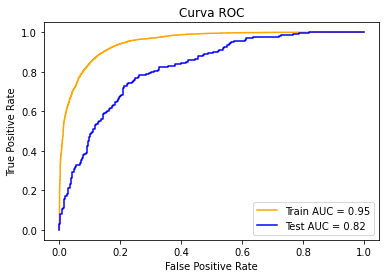

Parcelas con acierto:  35 de 38   92.11%
Exito min:  0.40532376581602547 
Exito max:  0.9525010697342136 
Exito promedio:  0.6888317074947206
Exito * accuracy =  0.5374700033478543
Exito * accuracy / (Exito + accuracy) =  0.3658511209930414
              precision    recall  f1-score   support

           0       0.86      0.89      0.87       570
           1       0.62      0.55      0.59       190

    accuracy                           0.81       760
   macro avg       0.74      0.72      0.73       760
weighted avg       0.80      0.81      0.80       760



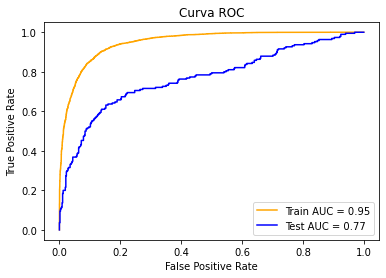

Parcelas con acierto:  33 de 38   86.84%
Exito min:  0.2974061019204223 
Exito max:  0.9340353206537354 
Exito promedio:  0.6556185744416477
Exito * accuracy =  0.5279454836293268
Exito * accuracy / (Exito + accuracy) =  0.361388243786843
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       570
           1       0.53      0.46      0.49       190

    accuracy                           0.76       760
   macro avg       0.68      0.66      0.67       760
weighted avg       0.75      0.76      0.76       760



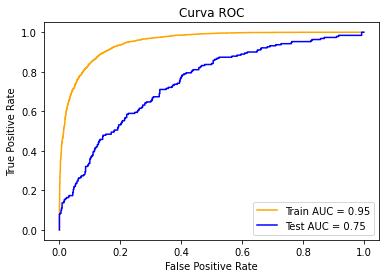

Parcelas con acierto:  27 de 38   71.05%
Exito min:  0.28324611324403737 
Exito max:  0.8640673241613803 
Exito promedio:  0.5808596034365517
Exito * accuracy =  0.44328759209631585
Exito * accuracy / (Exito + accuracy) =  0.32982278333338083
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       570
           1       0.53      0.48      0.50       190

    accuracy                           0.76       760
   macro avg       0.68      0.67      0.67       760
weighted avg       0.76      0.76      0.76       760



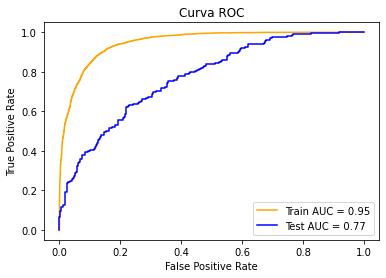

Parcelas con acierto:  28 de 38   73.68%
Exito min:  0.2805249138841764 
Exito max:  0.8897740292756545 
Exito promedio:  0.6293758244931297
Exito * accuracy =  0.47948500313358167
Exito * accuracy / (Exito + accuracy) =  0.3446512533213092
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       570
           1       0.45      0.42      0.43       190

    accuracy                           0.73       760
   macro avg       0.63      0.62      0.63       760
weighted avg       0.72      0.73      0.72       760



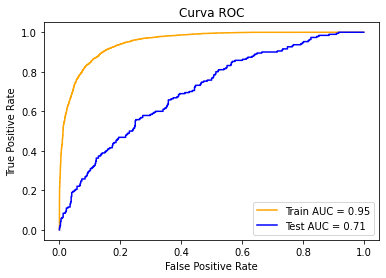

Parcelas con acierto:  28 de 38   73.68%
Exito min:  0.24985519126729144 
Exito max:  0.9232248083343246 
Exito promedio:  0.588083047485585
Exito * accuracy =  0.42790779639411647
Exito * accuracy / (Exito + accuracy) =  0.32522842552432624
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       570
           1       0.54      0.40      0.46       190

    accuracy                           0.76       760
   macro avg       0.68      0.64      0.65       760
weighted avg       0.75      0.76      0.75       760



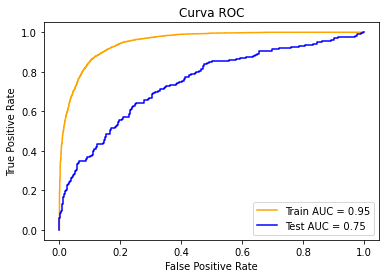

Parcelas con acierto:  26 de 38   68.42%
Exito min:  0.2842591544317259 
Exito max:  0.9373636821722692 
Exito promedio:  0.5804643525922409
Exito * accuracy =  0.4437497221790684
Exito * accuracy / (Exito + accuracy) =  0.32994064413106006


In [106]:
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[-1,1], 
                                   algoritmo=LGBMClassifier, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10
                                  )

- Con normalizacion entre 0 y 1 y umbral de 0.6:
  - Hay un modelo con accuracy de 0.8. Este modelo tiene buenos valores de precision y recall tanto para la clase 1 como para la 0. Acierta 31/38 (81%) de las parcelas y tiene un exito de 0.6448647699681269 (Exito regular).
  - El maximo de parcelas ha sido 35/38 (89%) con un exito de 0.6269087238081987. Tiene buenos valores de precision y recall, aunque no llegan al nivel del del punto de encima.
  - El mayor exito es 0.6727591155037314, pero con un accuracy de 0.77 y acertando 33/38 (86%). Con la nueva metrica de Exito*accuracy, este modelo tendria un valor de 0.51.
- Con normalizacion entre -1 y 1 y umbral de 0.6:
  - hay un modelo que supera el 0.8 de accuracy (0.81) el cual acierta 33/38 (86%) parcelas y tiene un exito de 0.6556185744416477. Ademas tiene buenos valores de precision y recall para ambas clases.
  - El maximo de parcelas ha sido 35/38 (92%) con un exito de 0.6888317074947206, y ademas con un accuracy de 0.78.
  - El mayor exito ha sido 0.6888317074947206 en la prueba del punto superior.

Ahora voy a probar con XGBoost y con LGBM con sus propias librerias:

Al entrenar un modelo de XGBoost, hay una variedad de parámetros que se pueden ajustar para mejorar el rendimiento del modelo. Aquí hay una breve explicación de algunos de los parámetros más comunes que se pueden ajustar:

- `max_depth`: La profundidad máxima del árbol de decisión. Se utiliza para controlar la complejidad del modelo. Un valor más alto puede llevar a un sobreajuste, mientras que un valor más bajo puede llevar a un subajuste.

- `learning_rate`: Controla la tasa de aprendizaje del modelo. Un valor más alto puede hacer que el modelo converja más rápido, pero también puede hacer que el modelo sea más sensible a los valores atípicos y al sobreajuste.

- `n_estimators`: El número de árboles que se utilizan en el modelo. Un valor más alto puede llevar a un mejor rendimiento, pero también puede aumentar el tiempo de entrenamiento.

- `subsample`: La fracción de las observaciones de entrenamiento que se utilizan para ajustar cada árbol. Un valor más bajo puede reducir el sobreajuste, pero también puede reducir el rendimiento.

- `colsample_bytree`: La fracción de las características que se utilizan para ajustar cada árbol. Un valor más bajo puede reducir el sobreajuste, pero también puede reducir el rendimiento.

- `gamma`: El valor mínimo que debe reducir la función de costo para que se cree un nuevo nodo en el árbol. Un valor más alto puede reducir el sobreajuste, pero también puede reducir el rendimiento.

- `alpha`: El parámetro de regularización L1. Un valor más alto puede reducir el sobreajuste, pero también puede reducir el rendimiento.

- `lambda`: El parámetro de regularización L2. Un valor más alto puede reducir el sobreajuste, pero también puede reducir el rendimiento.

- `objective`: La función de pérdida que se utiliza para ajustar el modelo. Esto se puede configurar en función del tipo de problema que se esté resolviendo (por ejemplo, clasificación binaria, clasificación multiclase o regresión).

Estos son solo algunos de los parámetros que se pueden ajustar en XGBoost. La elección de los parámetros óptimos dependerá del conjunto de datos y del problema que se esté resolviendo. Por lo general, se utiliza un enfoque de búsqueda de hiperparámetros para encontrar los valores óptimos de los parámetros del modelo.


El parámetro `objective` en XGBoost y LightGBM se utiliza para especificar el tipo de problema que se está abordando y, por lo tanto, la función de pérdida que se debe optimizar. Algunos de los valores que se pueden utilizar en este parámetro son:

- Para regresión: `reg:squarederror`, `reg:squaredlogerror`, `reg:pseudohubererror`, `reg:gamma`, `reg:tweedie`.
- Para clasificación binaria: `binary:logistic`, `binary:logitraw`, `binary:hinge`.
- Para clasificación multiclase: `multi:softmax`, `multi:softprob`.
- Para ranking: `rank:pairwise`, `rank:ndcg`, `rank:map`.
- Para personalizar la función de pérdida: `custom`.

Cada uno de estos valores determina cómo se calcula la pérdida y cómo se entrena el modelo para optimizar esta pérdida. Por lo tanto, es importante elegir el valor correcto de `objective` en función del tipo de problema que se está abordando.


El parámetro `eval_metric` en XGBoost y LightGBM se utiliza para especificar la métrica que se utilizará para evaluar la calidad de la predicción en el conjunto de validación o prueba. Algunos de los valores que se pueden utilizar en este parámetro son:

- Para regresión: `rmse`, `mae`, `logloss`.
- Para clasificación binaria: `error`, `auc`, `logloss`, `aucpr`.
- Para clasificación multiclase: `merror`, `mlogloss`.
- Para ranking: `ndcg`, `map`.
- Para personalizar la métrica: `custom`.

Cada una de estas métricas se utiliza para evaluar la calidad de la predicción en función del tipo de problema que se está abordando. Por lo tanto, es importante elegir la métrica adecuada en función de los objetivos del proyecto y del tipo de problema que se está abordando.


Voy a probar con los parametros que ha usado Mario:

objective: binary:logistic
use_label_encoder: None
base_score: 0.5
booster: gbtree
callbacks: None
colsample_bylevel: 1
colsample_bynode: 1
colsample_bytree: 0.9657249704671855
early_stopping_rounds: None
enable_categorical: False
eval_metric: auc
feature_types: None
gamma: 0
gpu_id: 0
grow_policy: depthwise
importance_type: None
interaction_constraints: 
learning_rate: 0.092
max_bin: 256
max_cat_threshold: 64
max_cat_to_onehot: 4
max_delta_step: 0
max_depth: 141
max_leaves: 0
min_child_weight: 2.8915804320720007
missing: nan
monotone_constraints: ()
n_estimators: 145
n_jobs: 0
num_parallel_tree: 1
predictor: gpu_predictor
random_state: 2027
reg_alpha: 0
reg_lambda: 2.4958860070369515
sampling_method: uniform
scale_pos_weight: 5.6052968104215815
subsample: 1
tree_method: gpu_hist
validate_parameters: 1
verbosity: 0
min_child_samples: 14
subsample_for_bin: 5
max_leaf_nodes: 27
eta: 0.037211579035864056
seed: 2027
              precision    recall  f1-score   support

           0       

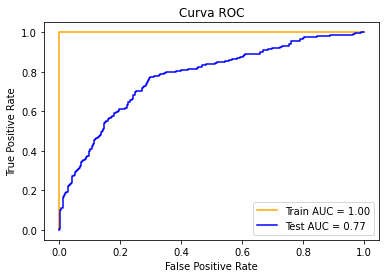

Parcelas con acierto:  37 de 39   94.87%
Exito min:  0.4305721140825276 
Exito max:  0.9950316 
Exito promedio:  0.8024971342800001
Exito * accuracy =  0.5905555834316925
Exito * accuracy / (Exito + accuracy) =  0.3838778391967274
              precision    recall  f1-score   support

           0       0.91      0.70      0.79       585
           1       0.46      0.78      0.58       195

    accuracy                           0.72       780
   macro avg       0.69      0.74      0.69       780
weighted avg       0.80      0.72      0.74       780



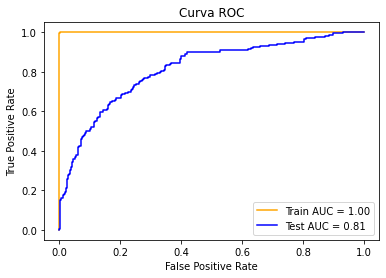

Parcelas con acierto:  36 de 39   92.31%
Exito min:  0.42676451154369915 
Exito max:  0.99167496 
Exito promedio:  0.8159326064003931
Exito * accuracy =  0.5868438361418212
Exito * accuracy / (Exito + accuracy) =  0.38226800186693355
              precision    recall  f1-score   support

           0       0.86      0.69      0.77       585
           1       0.42      0.68      0.52       195

    accuracy                           0.69       780
   macro avg       0.64      0.68      0.64       780
weighted avg       0.75      0.69      0.70       780



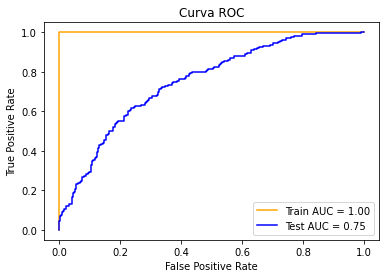

Parcelas con acierto:  38 de 39   97.44%
Exito min:  0.4377759544201714 
Exito max:  0.99048483 
Exito promedio:  0.777598123129649
Exito * accuracy =  0.5333525588132849
Exito * accuracy / (Exito + accuracy) =  0.36443742895116915
              precision    recall  f1-score   support

           0       0.86      0.72      0.78       585
           1       0.44      0.66      0.53       195

    accuracy                           0.70       780
   macro avg       0.65      0.69      0.65       780
weighted avg       0.76      0.70      0.72       780



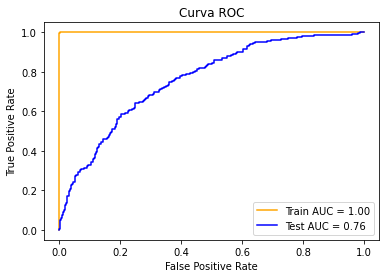

Parcelas con acierto:  37 de 39   94.87%
Exito min:  0.4386406592084542 
Exito max:  0.9938923 
Exito promedio:  0.7844483359720114
Exito * accuracy =  0.5511252411700798
Exito * accuracy / (Exito + accuracy) =  0.37062584473915616
              precision    recall  f1-score   support

           0       0.90      0.71      0.79       570
           1       0.47      0.77      0.58       190

    accuracy                           0.73       760
   macro avg       0.69      0.74      0.69       760
weighted avg       0.79      0.72      0.74       760



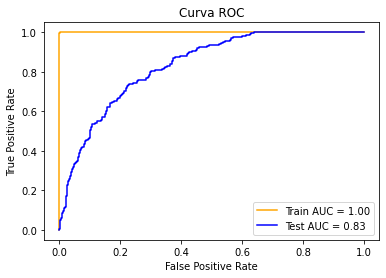

Parcelas con acierto:  36 de 38   94.74%
Exito min:  0.5713635 
Exito max:  0.99466455 
Exito promedio:  0.8643976390725667
Exito * accuracy =  0.6266882883276108
Exito * accuracy / (Exito + accuracy) =  0.3942929528278972
              precision    recall  f1-score   support

           0       0.87      0.76      0.81       570
           1       0.48      0.65      0.55       190

    accuracy                           0.74       760
   macro avg       0.67      0.71      0.68       760
weighted avg       0.77      0.74      0.75       760



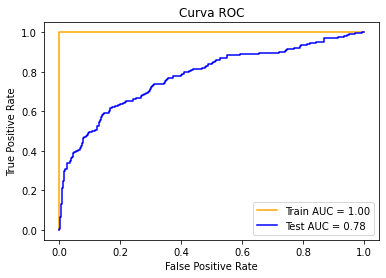

Parcelas con acierto:  30 de 38   78.95%
Exito min:  0.41819544842860384 
Exito max:  0.99422896 
Exito promedio:  0.8084453510212208
Exito * accuracy =  0.595696574436689
Exito * accuracy / (Exito + accuracy) =  0.38549240273329644
              precision    recall  f1-score   support

           0       0.88      0.77      0.82       570
           1       0.49      0.68      0.57       190

    accuracy                           0.75       760
   macro avg       0.69      0.72      0.70       760
weighted avg       0.78      0.75      0.76       760



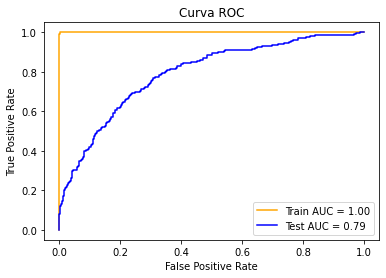

Parcelas con acierto:  34 de 38   89.47%
Exito min:  0.44443292893443914 
Exito max:  0.9878796 
Exito promedio:  0.7676081132859669
Exito * accuracy =  0.5726760529383463
Exito * accuracy / (Exito + accuracy) =  0.3783384453095891
              precision    recall  f1-score   support

           0       0.87      0.75      0.81       570
           1       0.47      0.68      0.56       190

    accuracy                           0.73       760
   macro avg       0.67      0.71      0.68       760
weighted avg       0.77      0.73      0.74       760



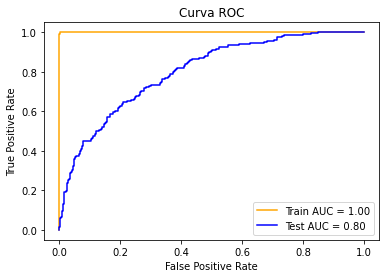

Parcelas con acierto:  34 de 38   89.47%
Exito min:  0.3128139299374169 
Exito max:  0.99021506 
Exito promedio:  0.8278372280089054
Exito * accuracy =  0.6045390283486085
Exito * accuracy / (Exito + accuracy) =  0.3879974832289112
              precision    recall  f1-score   support

           0       0.86      0.73      0.79       570
           1       0.45      0.66      0.53       190

    accuracy                           0.71       760
   macro avg       0.66      0.69      0.66       760
weighted avg       0.76      0.71      0.73       760



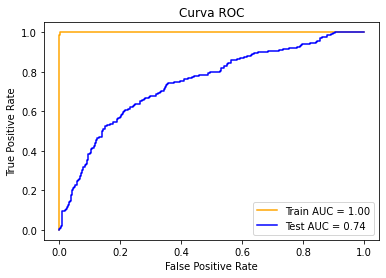

Parcelas con acierto:  35 de 38   92.11%
Exito min:  0.3327921592682934 
Exito max:  0.99156415 
Exito promedio:  0.7824605950556504
Exito * accuracy =  0.5559588438553305
Exito * accuracy / (Exito + accuracy) =  0.372380253180266
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       570
           1       0.45      0.59      0.51       190

    accuracy                           0.72       760
   macro avg       0.65      0.68      0.66       760
weighted avg       0.75      0.72      0.73       760



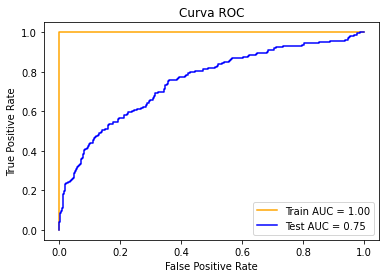

Parcelas con acierto:  34 de 38   89.47%
Exito min:  0.34422379981957235 
Exito max:  0.9944876 
Exito promedio:  0.725235313663913
Exito * accuracy =  0.5219785744396848
Exito * accuracy / (Exito + accuracy) =  0.3612378081858811


In [117]:
import xgboost as xgb
import joblib

# Cargar el modelo
xgb_model = joblib.load('bestmodels/Xgbm_model_481')

# Obtener los parámetros del modelo
params = xgb_model.get_params()

# Imprimir los nombres de los parámetros y sus valores
for key, value in params.items():
    print(f"{key}: {value}")
    
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[-1,1], 
                                   params=params, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10,
                                   XGBoost = True,
                                  )    

En XGBoost, Mario ha logrado obtener un accuracy de 0.98 con estos parametros pero yo lo maximo que he conseguido es 0.75, asi que deberia probar con distintas columnas de informacion.

boosting_type: gbdt
class_weight: None
colsample_bytree: 1.0
importance_type: split
learning_rate: 0.11533354417560811
max_depth: 99
min_child_samples: 73
min_child_weight: 0.001
min_split_gain: 0.0
n_estimators: 426
n_jobs: -1
num_leaves: 44
objective: None
random_state: 2027
reg_alpha: 0.0
reg_lambda: 0.0
silent: True
subsample: 1.0
subsample_for_bin: 200000
subsample_freq: 0
lambda_l1: 0.005362644132692479
lambda_l2: 0.09014662034945402
feature_fraction: 0.9237744994047856
bagging_fraction: 0.9285725886092697
bagging_freq: 2
min_data_in_leaf: 2
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subs

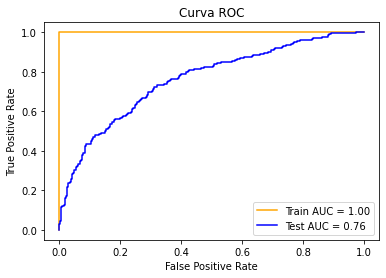

Parcelas con acierto:  33 de 39   84.62%
Exito min:  0.3053762688545352 
Exito max:  0.9943320176005372 
Exito promedio:  0.6706796771436031
Exito * accuracy =  0.5253657470958224
Exito * accuracy / (Exito + accuracy) =  0.3613212146729658
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current 

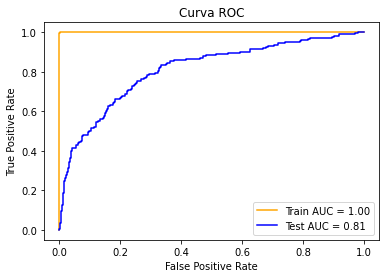

Parcelas con acierto:  36 de 39   92.31%
Exito min:  0.2767406440000955 
Exito max:  0.9866318837627023 
Exito promedio:  0.6957161443156582
Exito * accuracy =  0.5440857026058352
Exito * accuracy / (Exito + accuracy) =  0.3681808739981895
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current 

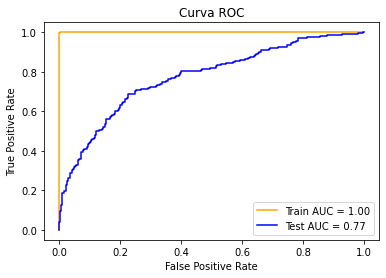

Parcelas con acierto:  34 de 39   87.18%
Exito min:  0.32205976143585935 
Exito max:  1.0544958911373785 
Exito promedio:  0.6832481103476038
Exito * accuracy =  0.5282033468456476
Exito * accuracy / (Exito + accuracy) =  0.3626960566650326
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current

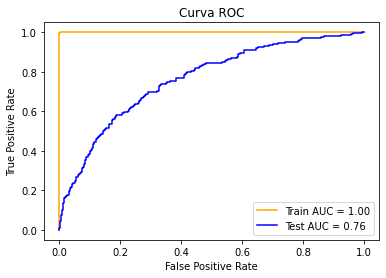

Parcelas con acierto:  34 de 39   87.18%
Exito min:  0.27457968820227313 
Exito max:  1.0275089616305395 
Exito promedio:  0.6520134089672968
Exito * accuracy =  0.5040565200093333
Exito * accuracy / (Exito + accuracy) =  0.35370145223446275
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Curren

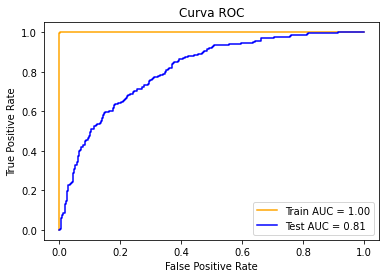

Parcelas con acierto:  35 de 38   92.11%
Exito min:  0.38153553452494027 
Exito max:  1.1411541820938176 
Exito promedio:  0.7264319870517654
Exito * accuracy =  0.5715872740223101
Exito * accuracy / (Exito + accuracy) =  0.3777156279388405
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current

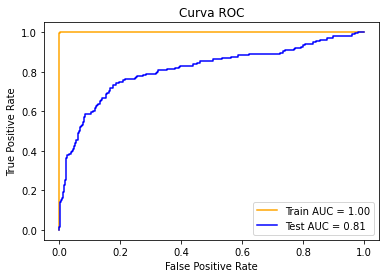

Parcelas con acierto:  31 de 38   81.58%
Exito min:  0.3258622063412148 
Exito max:  1.1377261161746095 
Exito promedio:  0.7093145570750551
Exito * accuracy =  0.5842512009591901
Exito * accuracy / (Exito + accuracy) =  0.38111654967169173
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current

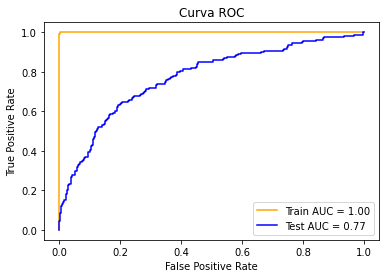

Parcelas con acierto:  31 de 38   81.58%
Exito min:  0.3854553047434175 
Exito max:  1.0704591776543633 
Exito promedio:  0.6507468357066916
Exito * accuracy =  0.5103225185278791
Exito * accuracy / (Exito + accuracy) =  0.3556360154204248
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current 

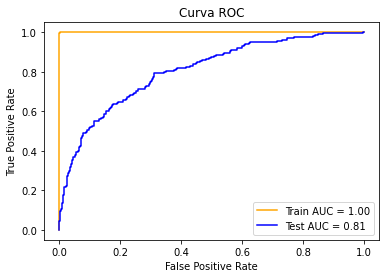

Parcelas con acierto:  32 de 38   84.21%
Exito min:  0.184686765873516 
Exito max:  0.9457608824081993 
Exito promedio:  0.6664718100759636
Exito * accuracy =  0.5358082578373865
Exito * accuracy / (Exito + accuracy) =  0.3643915052747483
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current v

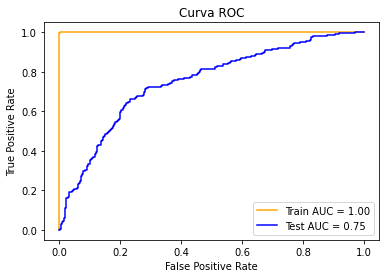

Parcelas con acierto:  33 de 38   86.84%
Exito min:  0.3364013361715177 
Exito max:  1.0016746207316236 
Exito promedio:  0.6547684232917385
Exito * accuracy =  0.4962455418632123
Exito * accuracy / (Exito + accuracy) =  0.35128370008332005
[LightGBM] [Warning] Unknown parameter: importance_type
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] feature_fraction is set=0.9237744994047856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9237744994047856
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=73 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] bagging_fraction is set=0.9285725886092697, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9285725886092697
[LightGBM] [Warning] lambda_l1 is set=0.005362644132692479, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005362644132692479
[LightGBM] [Warning] lambda_l2 is set=0.09014662034945402, reg_lambda=0.0 will be ignored. Current

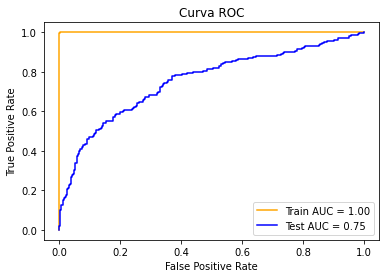

Parcelas con acierto:  28 de 38   73.68%
Exito min:  0.35161189636889995 
Exito max:  0.9757909757317244 
Exito promedio:  0.6128958694200396
Exito * accuracy =  0.48870381166913685
Exito * accuracy / (Exito + accuracy) =  0.3465334937363694


In [23]:
import lightgbm as lgb
import joblib

# Cargar el modelo
lgb_model = joblib.load('bestmodels/lgbm_model_152')

# Obtener los parámetros del modelo
params = lgb_model.get_params()

# Imprimir los nombres de los parámetros y sus valores
for key, value in params.items():
    print(f"{key}: {value}")
    
entrenarUndersamplingNormalizacion(df=df, 
                                   normalizacion=[0,1], 
                                   params=params, 
                                   random_state=33, 
                                   umbral=0.6, 
                                   n_splits=10,
                                   LGBM = True,
                                  )    


En XGBoost, Mario ha logrado obtener un accuracy de 0.88 con estos parametros pero yo lo maximo que he conseguido es 0.82, asi que deberia probar con distintas columnas de informacion.

Voy a crear otros notebooks para repetir estas pruebas pero para distintos datos como con la precipitacion acumulada de 3 dias, la presion, etc...

Conclusiones: Los mejores modelos han sido:
 - RandomForestRegression, norm = [0,1], threshold = 0.6:
 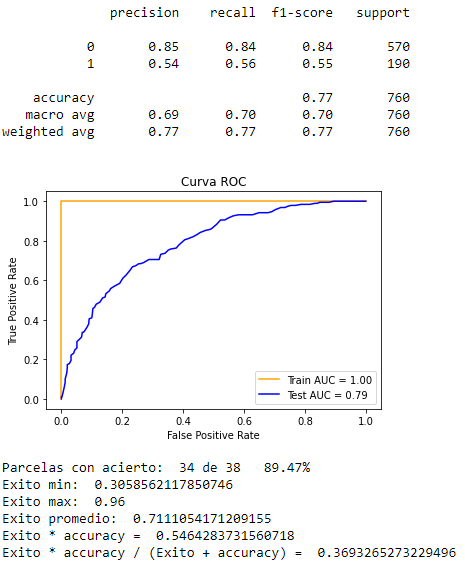
 - XGBoostClassifier, norm = [-1, 1], threshold = 0.6:
 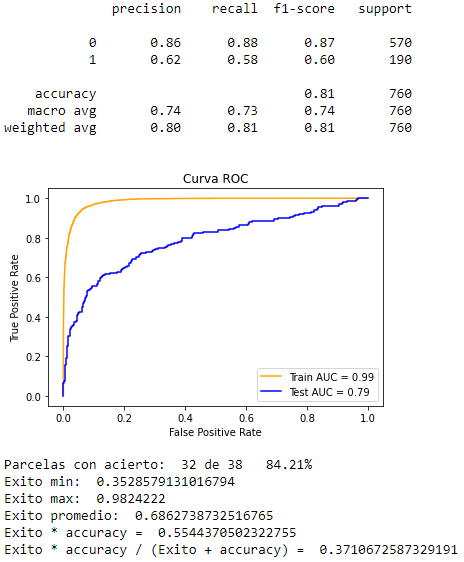
 - XGBoostClassifier, norm = [-1, 1], threshold = 0.6 (otra vez):
 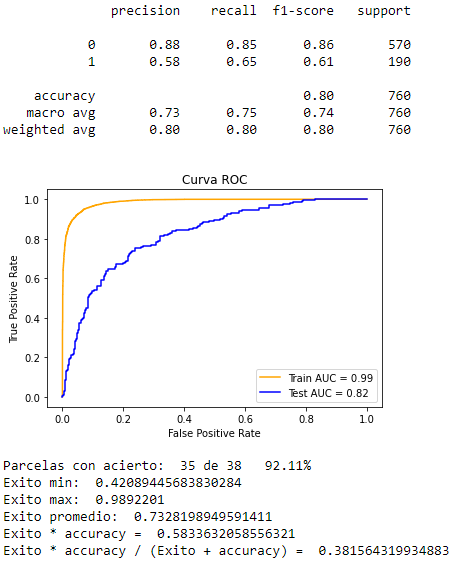
 - XGBoostClassifier, norm = [0, 1], threshold = 0.6:
 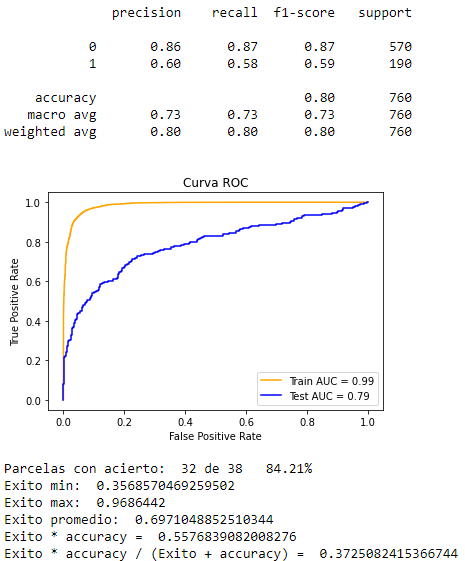
 - XGBoostClassifier, norm = [0, 1], threshold = 0.6 (otra vez):
 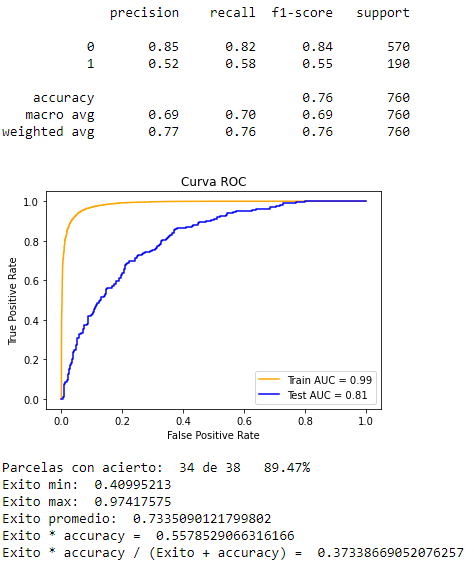
 - LGBM, norm = [-1, 1], threshold = 0.6:
 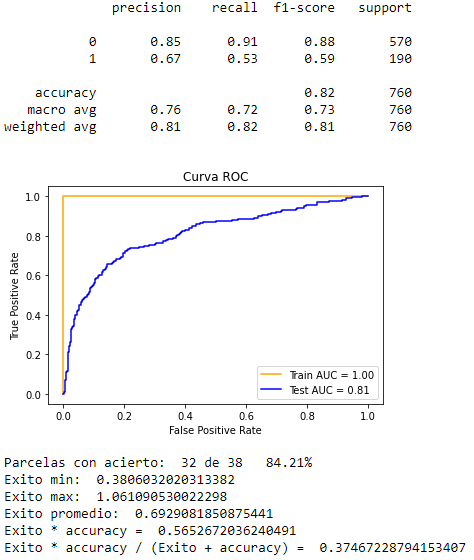
 - LGBM, norm = [0, 1], threshold = 0.6:
 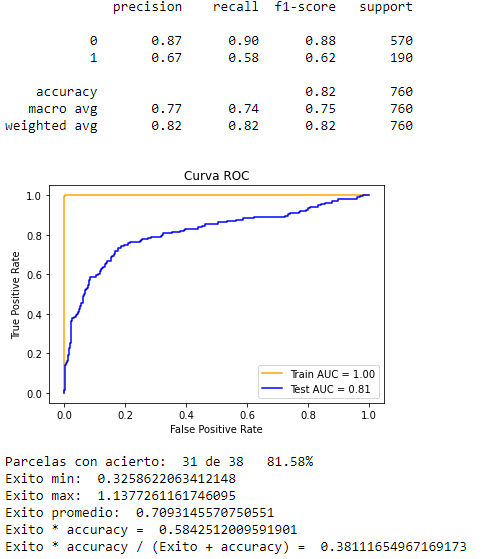